# Optics Calculations

**G. Sterbini, CERN, BE-ABP-INC**

With the invaluable contributions of **S. Kostoglou** and **M. Topp-Mugglestone**.

A special thanks goes to G. Iadarola, P. Bélanger and all the `Xsuite` community.

## The CAS-24 

We will study a CAS Advanced (proton) Synchrotron with a flat bottom momentum of 2.4 GeV/c and a top momentup up to 24 GeV/c (let's call it **CAS-24**). We can get inspired by the sister machines/studies, e.g., AGS (BNL), PS (CERN), SIS100 (GSI), NICA (DUBNA), Booster (FERMILAB), U-70 (IHEP, Protvino), MR (J-PARC), KEK-PS (KEK)...

&#x1F449; **It is a 500 m ring with 25 lattice FODO cells.**

We will use ['Xsuite' code](https://xsuite.readthedocs.io/en/latest/). To install ['Xsuite' code](https://xsuite.readthedocs.io/en/latest/) you can follow the instructions [here](https://xsuite.readthedocs.io/en/latest/installation.html).

Let's try to execute and to study step-by-step this notebook.

In [1]:
import numpy as np
import math
import pandas as pd
import xpart as xp
import xtrack as xt
import xplt
from matplotlib import pyplot as plt
import warnings

## The CAS-24 beam parameters

In [2]:
def BeamParameters(pc_GeV, en_x_m=5e-6, en_y_m=5e-6, deltap_p=1e-3, verbose=True):
    from scipy.constants import speed_of_light
    import scipy.constants as sco
    
    # Tm, beam rigidity
    Brho_Tm=1e9/speed_of_light*pc_GeV
    # GeV, rest mass energy
    E_0_GeV=sco.physical_constants['proton mass energy equivalent in MeV'][0]/1000 
    E_tot_GeV=np.sqrt(pc_GeV**2+E_0_GeV**2)
    E_kin_GeV=E_tot_GeV-E_0_GeV
    gamma_r=E_tot_GeV/E_0_GeV
    beta_r=pc_GeV/E_tot_GeV
    eg_x_m=en_x_m/gamma_r/beta_r
    eg_y_m=en_y_m/gamma_r/beta_r

    if verbose:
        print(f'''Particle type: proton
        Beam momentum= {pc_GeV:2.3f} GeV/c
        normalized x-emittance= {en_x_m*1e6:2.3f} mm mrad
        normalized y-emittance= {en_y_m*1e6:2.3f} mm mrad
        deltap/p= {deltap_p} 
        -> Beam total energy= {E_tot_GeV:2.3f} GeV
        -> Beam kinetic energy= {E_kin_GeV:2.3f} GeV
        -> Beam rigidity= {Brho_Tm:2.3f} Tm
        -> relativistic beta= {beta_r:2.5f}
        -> relativistic gamma= {gamma_r:2.3f}
        -> geometrical x-emittance= {eg_x_m*1e6:2.3f} mm mrad
        -> geometrical y-emittance= {eg_y_m*1e6:2.3f} mm mrad
        ''')
    return {'pc_GeV': pc_GeV,'Brho_Tm': Brho_Tm,'E_0_GeV': E_0_GeV, 'E_tot_GeV':E_tot_GeV,
            'E_kin_GeV': E_kin_GeV, 'gamma_r': gamma_r, 'beta_r':beta_r, 'en_x_m':en_x_m, 'en_y_m':en_y_m,
            'eg_x_m':eg_x_m, 'eg_y_m':eg_y_m, 'deltap_p':deltap_p}

print('====== Injection Energy ======')
beamFB=BeamParameters(2.4, en_x_m=5e-6, en_y_m=5e-6, deltap_p=2e-3)

print('======== Top Energy ========')
beamFT=BeamParameters(24, en_x_m=5e-6, en_y_m=5e-6, deltap_p=2e-4)


====== Injection Energy ======
Particle type: proton
        Beam momentum= 2.400 GeV/c
        normalized x-emittance= 5.000 mm mrad
        normalized y-emittance= 5.000 mm mrad
        deltap/p= 0.002 
        -> Beam total energy= 2.577 GeV
        -> Beam kinetic energy= 1.639 GeV
        -> Beam rigidity= 8.006 Tm
        -> relativistic beta= 0.93136
        -> relativistic gamma= 2.746
        -> geometrical x-emittance= 1.955 mm mrad
        -> geometrical y-emittance= 1.955 mm mrad
        
======== Top Energy ========
Particle type: proton
        Beam momentum= 24.000 GeV/c
        normalized x-emittance= 5.000 mm mrad
        normalized y-emittance= 5.000 mm mrad
        deltap/p= 0.0002 
        -> Beam total energy= 24.018 GeV
        -> Beam kinetic energy= 23.080 GeV
        -> Beam rigidity= 80.055 Tm
        -> relativistic beta= 0.99924
        -> relativistic gamma= 25.598
        -> geometrical x-emittance= 0.195 mm mrad
        -> geometrical y-emittance= 0.195 m

In [3]:
circum_m = 500. # m, machine circumference
ncell = 25
l_quad_m = 1 # m
l_dip_m = 3.5 # m
lcell_m = circum_m/ncell; # m

f_m = lcell_m/(2*np.sqrt(2)) # This will give pi/2 phase advance in thin lens approximation (no dipoles)

nQuadrupoles = 2*ncell
nDipoles = 4*ncell # four dipoles per cell
angleOfDipole_rad = 2*np.pi/nDipoles 
fieldOfDipole_T=  angleOfDipole_rad*beamFT['Brho_Tm']/l_dip_m
gradientOfQuadrupole_T_m = 1/f_m*beamFT['Brho_Tm']/l_quad_m
r_quadrupole_m = 0.05;
v_gap_dipole_m = 0.05;
h_gap_dipole_m = 0.10;

print(f'''
Machine parameters:

- Circumference = {circum_m} m
- Number of cells = {ncell}
- Cell length = {lcell_m} m
- Number of dipoles = {nDipoles}
- Dipole length = {l_dip_m} m
- Number of quadrupoles = {nQuadrupoles}
- Quadrupole length = {l_quad_m} m

Aperture parameters:

- Vertical gap of dipole = {v_gap_dipole_m*100} cm
- Horizontal gap of dipole = {h_gap_dipole_m*100} cm
- Radius of quadrupole = {r_quadrupole_m*100} cm


Derived parameters:

- Angle of dipole = {angleOfDipole_rad*1000:2.2f} mrad
- Field of dipole = {angleOfDipole_rad*beamFB['Brho_Tm']/l_dip_m:2.3f} -> {fieldOfDipole_T:2.2f} T
- Focal length (90 deg phase advance) = {f_m:2.2f} m
- Gradient of quadrupole = {1/f_m*beamFB['Brho_Tm']/l_quad_m:2.3f} -> {gradientOfQuadrupole_T_m:2.2f} T/m
- Field at the quadrupole aperture = {1/f_m*beamFB['Brho_Tm']/l_quad_m*r_quadrupole_m:2.3f} -> {gradientOfQuadrupole_T_m*r_quadrupole_m:2.2f} T
''')

rho = nDipoles*l_dip_m/2/np.pi
k1l_dip = 1/rho**2*l_dip_m
k1l_quad = 1/f_m


print(f'''
- rho = {rho:2.2f} m # bending radius (# Dipoles x dipole_length / 2 / np.pi)
- |k1l_dipole| = {k1l_dip:2.4f} 1/m (1/rho^2 x dipole_length)
- |k1l_quadrupole| = {k1l_quad:2.4f} 1/m
''')


Machine parameters:

- Circumference = 500.0 m
- Number of cells = 25
- Cell length = 20.0 m
- Number of dipoles = 100
- Dipole length = 3.5 m
- Number of quadrupoles = 50
- Quadrupole length = 1 m

Aperture parameters:

- Vertical gap of dipole = 5.0 cm
- Horizontal gap of dipole = 10.0 cm
- Radius of quadrupole = 5.0 cm


Derived parameters:

- Angle of dipole = 62.83 mrad
- Field of dipole = 0.144 -> 1.44 T
- Focal length (90 deg phase advance) = 7.07 m
- Gradient of quadrupole = 1.132 -> 11.32 T/m
- Field at the quadrupole aperture = 0.057 -> 0.57 T


- rho = 55.70 m # bending radius (# Dipoles x dipole_length / 2 / np.pi)
- |k1l_dipole| = 0.0011 1/m (1/rho^2 x dipole_length)
- |k1l_quadrupole| = 0.1414 1/m



You can compare the aperture/field of the dipole with the one of the other machines.

[CERN PS magnet aperture and field](https://cas.web.cern.ch/sites/default/files/BASIC-CAS%202021%20-%20Normal%20Conducting%20Magnets%20(Th%20Zickler).pdf#page=30)

[CERN SPS magnet aperture and field](https://cas.web.cern.ch/sites/default/files/BASIC-CAS%202021%20-%20Normal%20Conducting%20Magnets%20(Th%20Zickler).pdf#page=31)

## The CAS-24 lattice parameters

&#x2753;&#x2753;&#x2753; QUESTION at https://www.menti.com/aluvnsk27yo4

&#x2753;&#x2753;&#x2753;
**What it is a reasonable $\beta$_{max} to target?**

For a FODO (thin lens approximation, bend focusing neglect) of  length L, phase avance $\mu$, total deflection $\phi$ the following expression can be useful

\begin{equation}
\begin{aligned}
f &=\pm \frac{L }{4 \sin \frac{\mu}{2}} \\
\beta^{\pm} &=\frac{L \left(1 \pm \sin \frac{\mu}{2}\right)}{\sin \mu} \\
\alpha^{\pm} &=\pm\frac{1+\sin \frac{\mu}{2}}{\cos \frac{\mu}{2}} \\
D^{\pm} &=\frac{ L\ \phi\left[1 \pm \frac{1}{2} \sin \frac{\mu}{2}\right]}{4 \sin ^2 \frac{\mu}{2}}\\
\xi&=-\frac{1}{\pi} \tan \frac{\mu}{2}
\end{aligned}
\end{equation}

In [4]:
#Assuming 90 deg phase advance we have
import math
# Define the functions based on the provided formulas
def f(L, mu):
    return L / (4 * math.sin(mu / 2))

def beta(L, mu, sign):
    return (L * (1 + sign * math.sin(mu / 2))) / math.sin(mu)

def alpha(mu, sign):
    return sign*(+1 + math.sin(mu / 2)) / math.cos(mu / 2)

def D(L, phi, mu, sign):
    return (L * phi * (1 + sign * 0.5 * math.sin(mu / 2))) / (4 * (math.sin(mu / 2) ** 2))

def xi(mu):
    return -1 / math.pi * math.tan(mu / 2)

# Constants
L = lcell_m  # Assuming a value for L as it's not specified
phi = angleOfDipole_rad  # Assuming a value for phi as it's not specified
mu = math.pi / 2  # mu value

# Compute values for both signs (+ and -)
results = (
    f"\nFocal length: {f(L, mu):1.2f} m\n" 
    f"Qx,y: {mu*ncell/2/math.pi:1.2f}\n\n"
    f"beta_max: {beta(L, mu, 1):1.2f} m\n" 
    f"beta_min: {beta(L, mu, -1):1.2f} m\n" 
    f"alpha_max: {alpha(mu, 1):1.2f}\n" 
    f"alpha_min: {alpha(mu, -1):1.2f}\n\n" 
    f"D_max: {D(L, phi*nDipoles/ncell, mu, 1):1.2f} m\n" 
    f"D_min: {D(L, phi*nDipoles/ncell, mu, -1):1.2f} m\n" 
    f"Chromaticity : {xi(mu):1.2f}\n"
)
print(results)


Focal length: 7.07 m
Qx,y: 6.25

beta_max: 34.14 m
beta_min: 5.86 m
alpha_max: 2.41
alpha_min: -2.41

D_max: 3.40 m
D_min: 1.62 m
Chromaticity : -0.32



In [237]:
import xtrack as xt

env = xt.Environment()
env.particle_ref = xt.Particles(p0c=beamFB['pc_GeV']*1e9, mass0=xt.PROTON_MASS_EV)

env['k1'] = 1/f_m/l_quad_m

env['trim_kf'] = 0
env['trim_kd'] = 0

env['k1s_f'] = 0
env['k1s_d'] = 0

l_sext_m = 0.1
env['k2_f'] = 0
env['k2_d'] = 0

l_oct_m = 0.10
env['k3_f'] = 0
env['k3_d'] = 0

l_corrector_m = 0.10
 
env.new('mb', xt.Bend, k0=angleOfDipole_rad/l_dip_m, h=angleOfDipole_rad/l_dip_m, length=l_dip_m)   

env.new('qf_half', xt.Quadrupole, k1 = 'k1+trim_kf', k1s = 'k1s_f', length=l_quad_m/2)
env.new('qd_half', xt.Quadrupole, k1 = '-k1+trim_kd', k1s = 'k1s_d', length=l_quad_m/2)

env.new('sf', xt.Sextupole, k2 = 'k2_f', length=l_sext_m)
env.new('sd', xt.Sextupole, k2 = 'k2_d', length=l_sext_m)

env.new('of', xt.Octupole, k3 = 'k3_f', length=l_oct_m)
env.new('od', xt.Octupole, k3 = 'k3_d', length=l_oct_m)

env.new('corrector', xt.Bend, length=l_corrector_m)

env['rf_frequency'] = 0 # 1/my_twiss.T_rev0
env['voltage'] = 0

arc_cell = env.new_line(components=[
    env.new('start_cell', xt.Marker,  at =0),
    env.new('qf.1', 'qf_half',  at =l_quad_m/4, mode = 'replica'),
    env.new('sf.1', 'sf',  at =l_quad_m/2+l_sext_m/2, mode = 'replica'),
    env.new('mb.1', 'mb', at=lcell_m/8, mode = 'replica'),
    env.new('of.1', 'of',  at = -l_dip_m/2-l_oct_m/2, from_='mb.2', mode = 'replica'),
    env.new('mb.2', 'mb', at=lcell_m/4, from_ = 'mb.1', mode = 'replica'),
    env.new('mc.1', 'corrector',  at = -l_quad_m/4-l_corrector_m/2, from_='qd.1', mode = 'clone'),
    env.new('qd.1', 'qd_half', at=lcell_m/2-l_quad_m/4, mode = 'replica'),
    env.new('mid_cell', xt.Marker,  at =lcell_m/2),
    env.new('qd.2', 'qd_half', at=lcell_m/2+l_quad_m/4, mode = 'replica'),
    env.new('sd.1', 'sd',  at = l_quad_m/4+l_sext_m/2, from_='qd.2', mode = 'replica'),
    env.new('mb.3', 'mb', at=lcell_m/4, from_ = 'mb.2', mode = 'replica'),
    env.new('od.1', 'od',  at = -l_dip_m/2-l_oct_m/2, from_='mb.4', mode = 'replica'),
    env.new('mb.4', 'mb', at=lcell_m/4, from_ = 'mb.3', mode = 'replica'),
    env.new('mc.2', 'corrector',  at = -l_quad_m/4-l_corrector_m/2, from_='qf.2', mode = 'clone'),
    env.new('qf.2', 'qf_half', at = lcell_m-l_quad_m/4, mode = 'replica'),
    env.new('end_cell', xt.Marker, at=lcell_m),
    env.new('rf', xt.Cavity, voltage= 'voltage', frequency='rf_frequency', lag=0, at = 5),
    ])

for ii in range(ncell):
    env.new(f'cell{ii}', arc_cell, mode='clone')

ring = env.new_line(components=[f'cell{kk}' for kk in range(25)])

arc_cell_sampled = arc_cell.copy()
arc_cell_sampled.cut_at_s(np.linspace(0, lcell_m, 500))

# linking the orbit corrector to dedicated variables (each corrector has a dedicated PC)
for cell in range(25):
    env[f'k0_mc.1.cell{cell}'] = 0
    ring[f'mc.1.cell{cell}'].k0 = f'k0_mc.1.cell{cell}'
    env[f'k0_mc.2.cell{cell}'] = 0
    ring[f'mc.2.cell{cell}'].k0 = f'k0_mc.2.cell{cell}'

Slicing line:   0%|          | 0/25 [00:00<?, ?it/s]

## The machine geometry
After having verified the machine stability, let us check the machine geometry.

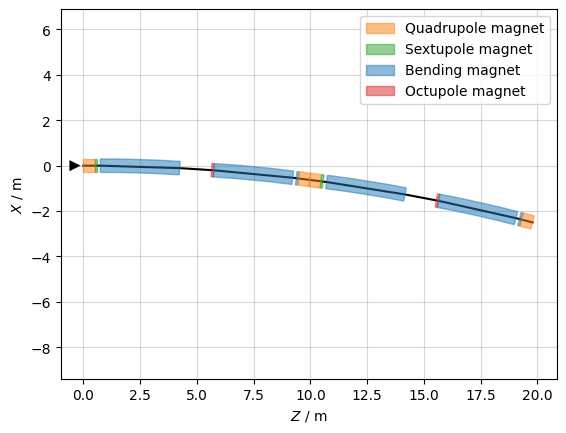

In [6]:
arc_cell.survey().plot()

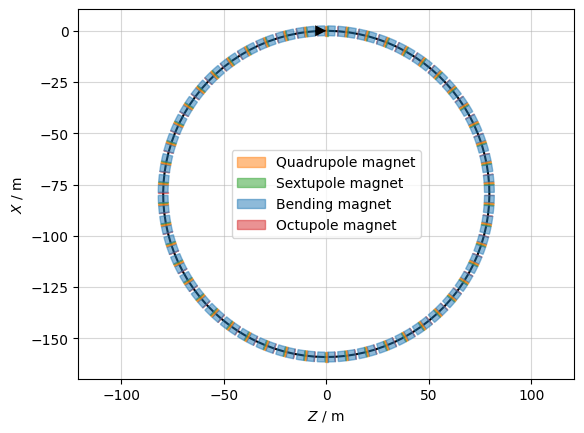

In [7]:
ring.survey().plot()

## The machine optics

Text(12, 6.3, 'min($\\beta$) in thin approx')

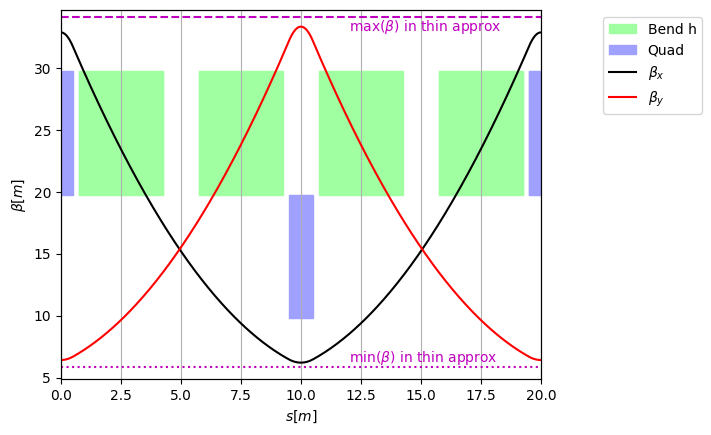

In [8]:
my_twiss = arc_cell_sampled.twiss4d()
my_twiss.plot(yl='betx bety')
plt.axhline(beta(L, mu, 1), color= 'm', ls ='--')
plt.axhline(beta(L, mu, -1), color= 'm', ls =':')
plt.text( x=12,y=33, s='max($\\beta$) in thin approx',color = 'm')
plt.text( x=12,y=6.3, s='min($\\beta$) in thin approx',color = 'm')

Text(12, -2.3, 'min($\\alpha$) in thin approx')

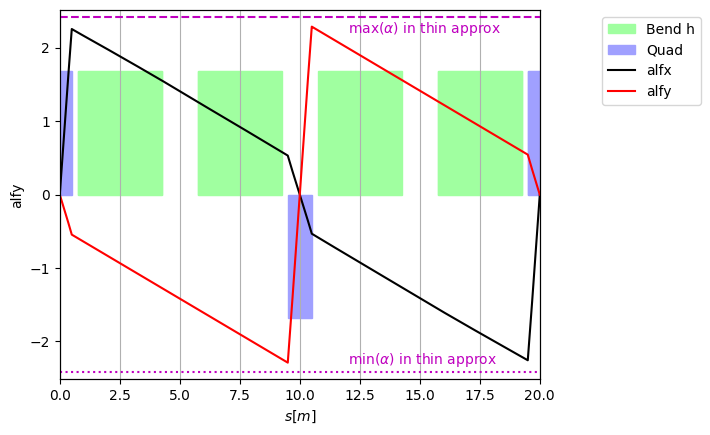

In [9]:
my_twiss.plot(yl='alfx alfy')
plt.axhline(alpha( mu, 1), color= 'm', ls ='--')
plt.axhline(alpha(mu, -1), color= 'm', ls =':')
plt.text( x=12,y=2.2, s='max($\\alpha$) in thin approx',color = 'm')
plt.text( x=12,y=-2.3, s='min($\\alpha$) in thin approx',color = 'm')

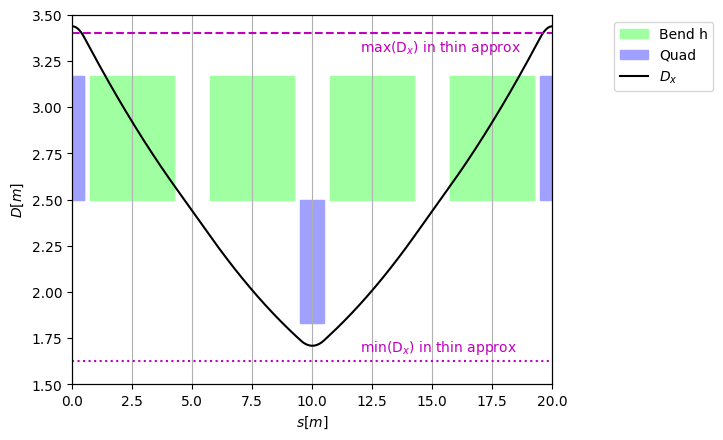

In [10]:
my_twiss.plot(yl='dx')
plt.axhline(D(L, phi*nDipoles/ncell, mu, 1), color= 'm', ls ='--')
plt.axhline(D(L, phi*nDipoles/ncell, mu, -1), color= 'm', ls =':')
plt.ylim(1.5, 3.5)
plt.text( x=12,y=3.3, s='max(D$_x$) in thin approx',color = 'm')
plt.text( x=12,y=1.68, s='min(D$_x$) in thin approx',color = 'm');

In [11]:
print(f'dqx: {my_twiss.dqx:2.4f} (to compare with {xi(mu):2.4f} of the thin approximation)')
print(f'dqy: {my_twiss.dqy:2.4f} (to compare with {xi(mu):2.4f} of the thin approximation)')


dqx: -0.2802 (to compare with -0.3183 of the thin approximation)
dqy: -0.2880 (to compare with -0.3183 of the thin approximation)


## We switch ON the RF and we analyze the 6D problem

In [12]:
my_twiss = ring.twiss4d()

def calculate_gamma_t(gamma, eta):
    """
    Calculate gamma transition (gamma_t) given gamma and slippage factor eta.

    Parameters:
    gamma (float): The Lorentz factor of the particle.
    eta (float): The slippage factor.

    Returns:
    float: The transition gamma (gamma_t).
    """
    gamma_t = gamma / math.sqrt(1 + eta * gamma**2)
    return gamma_t
    
print(f'The gamma of the transition energy is {calculate_gamma_t(my_twiss.gamma0, my_twiss.slip_factor)} GeV.')

The gamma of the transition energy is 5.672071092995206 GeV.


In [13]:
ring['rf.cell1'].voltage  = 1e6 # 1 MV
h_rf = 10
ring['rf.cell1'].frequency = h_rf/my_twiss.T_rev0 #
# energy is my_twiss.p0c/1e9 GeV

In [15]:
my_twiss = ring.twiss()

def is_symplectic(M):
    """Check if the matrix M is symplectic."""
    n = M.shape[0] // 2
    # Construct the symplectic matrix Omega
    my_block = np.array([[0, 1], [-1, 0]])
    omega = np.kron(np.eye(n), my_block)
    #return np.allclose(M.T @ omega @ M, omega)
    return M.T @ omega @ M -omega

OTM = my_twiss.get_R_matrix(start = my_twiss.name[0], end = my_twiss.name[-1])
df = pd.DataFrame(is_symplectic(OTM))

def highlight_red(value):
    if value > 1e-12:
        return "color: red; format: .2f"
    else:
        return ""

# Apply the styling
styled_df = (
    df.style  # Access the Styler object
    .map(highlight_red)  # Apply style to each cell
    .format("{:.2e}")    # Format in scientific notation
)
styled_df

Keep in mind that now the problem is non-linear and finding the jacobian of the symplectic map is more delicated (we will discuss more this aspect in the next minutes).

## Beam envelopes and machine aperture
As third step, we verify the machine aperture 

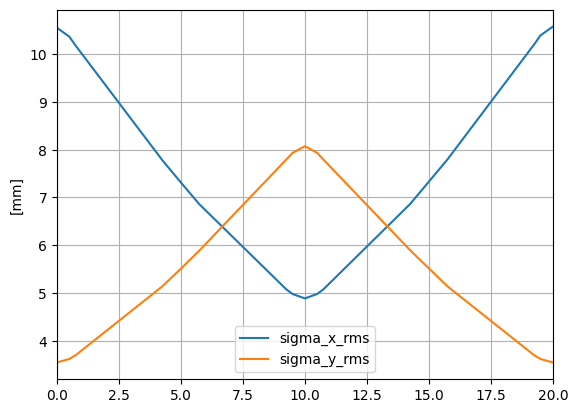

In [16]:
my_twiss = ring.twiss()
gemitt_x = beamFB['eg_x_m']
gemitt_y = beamFB['eg_y_m']
delta_rms = beamFB['deltap_p']

sigma_x = np.sqrt(gemitt_x*my_twiss.betx)
sigma_dx = delta_rms*my_twiss.dx
sigma_y = np.sqrt(gemitt_y*my_twiss.bety)
sigma_dy = delta_rms*my_twiss.dy
sigma_x_rms = np.sqrt(sigma_x**2+sigma_dx**2)
sigma_y_rms = np.sqrt(sigma_y**2+sigma_dy**2)

plt.plot(my_twiss.s, sigma_x_rms*1000, label='sigma_x_rms')
plt.plot(my_twiss.s, sigma_y_rms*1000, label='sigma_y_rms')
plt.xlim(0,20)
plt.ylabel('[mm]')
plt.grid()
plt.legend()

Equivalently you can compute the beam envelope using the `get_beam_covariance` method of the twiss table.

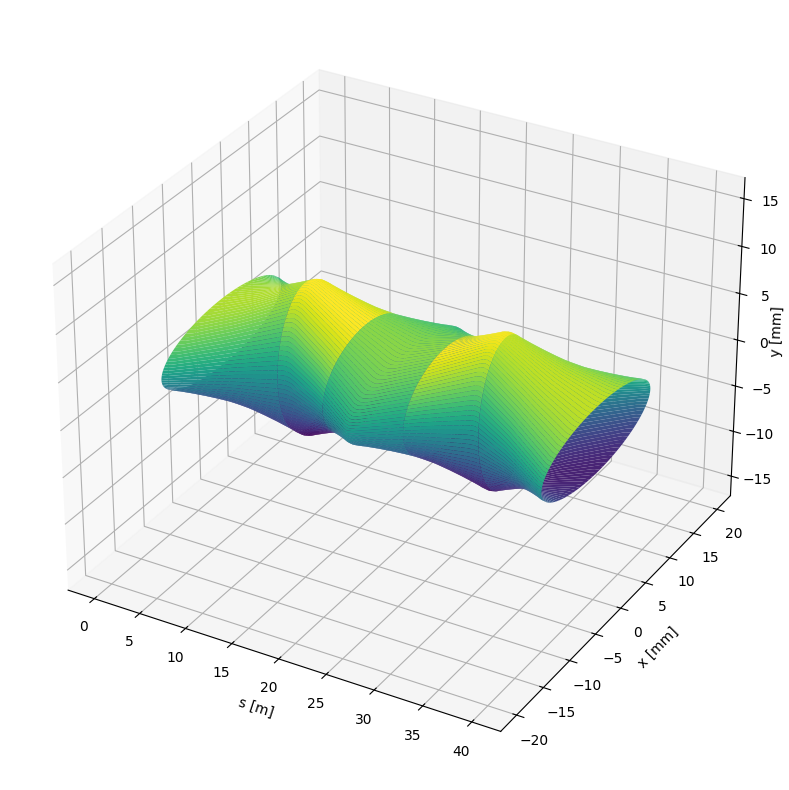

In [17]:
# Transverse normalized emittances

nemitt_x = beamFT['en_x_m']
nemitt_y = beamFT['en_y_m']
sigma_pzeta = delta_rms
gemitt_zeta = sigma_pzeta**2*my_twiss.bets0

beam_sizes = my_twiss.get_beam_covariance(nemitt_x=nemitt_x,
                                    nemitt_y=nemitt_y, gemitt_zeta = np.abs(gemitt_zeta))
from mpl_toolkits.mplot3d import Axes3D

# Define the range of s
my_limit = 50
s = beam_sizes.s[0:my_limit]  # Longitudinal position

# Define sigma_x(s) and sigma_y(s) as functions or arrays
sigma_x = beam_sizes.sigma_x[0:my_limit]*1e3
sigma_y = beam_sizes.sigma_y[0:my_limit]*1e3


# Create a meshgrid for theta (angle around the envelope)
theta = np.linspace(0, 2 * np.pi, 1000)

# Create the 3D arrays for plotting
S, T = np.meshgrid(s, theta)  # Meshgrid for s and theta

# Parametric equations for the 3D envelope
X = sigma_x * np.cos(T)  # X in the horizontal plane
Y = sigma_y * np.sin(T)  # Y in the vertical plane
Z = S  # Z is the longitudinal axis

# Create the 3D plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface representing the 3D envelope
ax.plot_surface(Z, X, Y, cmap='viridis', shade=True,rstride=10,
                        cstride=10,alpha=1,)

# Labels for axes
ax.set_xlabel('s [m]')
ax.set_ylabel('x [mm]')
ax.set_zlabel('''y [mm]\n\n''')
ax.axis('equal')
# Show the plot
plt.show()


Text(0.5, 0, 's [m]')

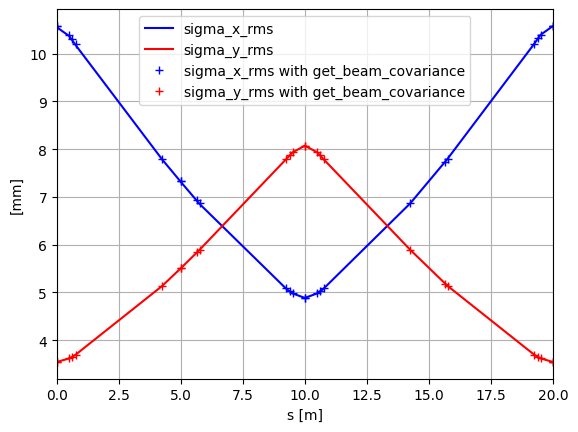

In [18]:

plt.plot(my_twiss.s, sigma_x_rms*1000,'b-', label='sigma_x_rms')
plt.plot(my_twiss.s, sigma_y_rms*1000,'r-', label='sigma_y_rms')
plt.plot(my_twiss.s, beam_sizes.sigma_x*1e3, '+b', label='sigma_x_rms with get_beam_covariance')
plt.plot(my_twiss.s, beam_sizes.sigma_y*1e3, '+r',label='sigma_y_rms with get_beam_covariance')

plt.xlim(0,20)
plt.ylabel('[mm]')
plt.grid()
plt.legend()

plt.xlabel('s [m]')

*** Maximum RMS bunch length 7.880434640492812m.
... distance to target bunch length: -2.0000e+00
... distance to target bunch length: 5.6629e+00
... distance to target bunch length: 2.4669e+00
... distance to target bunch length: -1.1371e-01
... distance to target bunch length: -2.6274e-03
... distance to target bunch length: -1.8568e-06
... distance to target bunch length: 8.4856e-06
--> Bunch length: 1.9999981431837117
--> Emittance: 0.41675306404294005


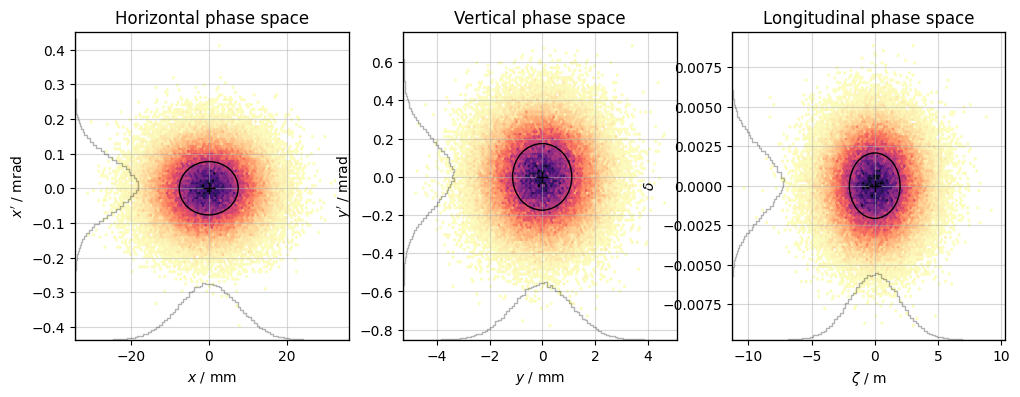

In [19]:
#ring.cycle(name_first_element='mid_cell.cell0')
ring.cycle(name_first_element='start_cell.cell0')
ring['rf.cell1'].voltage  = 1e6
n_part = 100000
sigma_z = 2.

from scipy.integrate import IntegrationWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=IntegrationWarning)
    particles = xp.generate_matched_gaussian_bunch(
             num_particles=n_part, #total_intensity_particles=1e10,
             nemitt_x=nemitt_x/10, nemitt_y=nemitt_y/10, sigma_z=sigma_z,
             line=ring)

plot = xplt.PhaseSpacePlot(particles, mean=(1, 1, 1),
    std=(1, 1, 1),)

## Misalignement and orbit errors

In [20]:
tt = ring.get_table()
tt_quad = tt.rows[tt.element_type == 'Quadrupole']

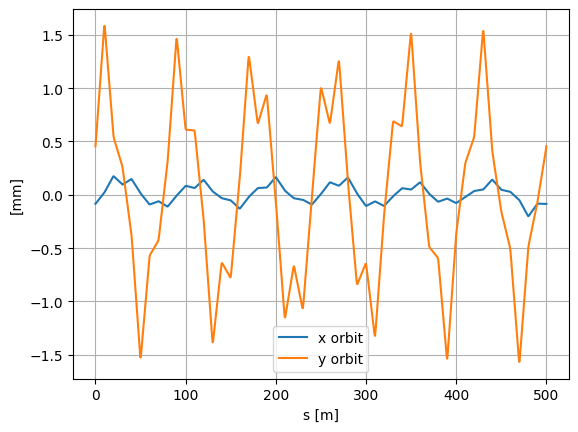

In [28]:
rgen = np.random.RandomState(1) # fix seed for random number generator
rgen = np.random.RandomState() # fix seed for random number generator

shift_x = rgen.randn(len(tt_quad)) * 0.01e-3 # 0.01 mm rms shift on all quads
shift_y = rgen.randn(len(tt_quad)) * 0.01e-3 # 0.01 mm rms shift on all quads
shift_z = rgen.randn(len(tt_quad)) * 0
for nn_quad, sx, sy, sz in zip(tt_quad.name, shift_x, shift_y, shift_z):
    ring.element_refs[nn_quad].shift_x = sx
    ring.element_refs[nn_quad].shift_y = sy
    ring.element_refs[nn_quad].shift_z = sz

my_twiss = ring.twiss()
plt.plot(my_twiss.s,my_twiss.x*1e3, label = 'x orbit')
plt.plot(my_twiss.s,my_twiss.y*1e3, label = 'y orbit')
plt.ylabel('[mm]')
plt.xlabel('s [m]')
plt.legend()
plt.grid()

for nn_quad, sx, sy, sz in zip(tt_quad.name, shift_x, shift_y, shift_z):
    ring.element_refs[nn_quad].shift_x = 0
    ring.element_refs[nn_quad].shift_y = 0
    ring.element_refs[nn_quad].shift_z = 0

&#x2753;&#x2753;&#x2753; QUESTION at https://www.menti.com/aluvnsk27yo4

**Why the V plane seems more affected by the misaligments?**


# Tune control
We will plot the current working point on the tune diagram.

In [29]:
twiss_before_correction = ring.twiss()
qx=twiss_before_correction.qx
qy=twiss_before_correction.qy
print(f'Qx= {qx:2.5f}, Qy= {qy:2.5f}')

Qx= 6.13432, Qy= 5.98378


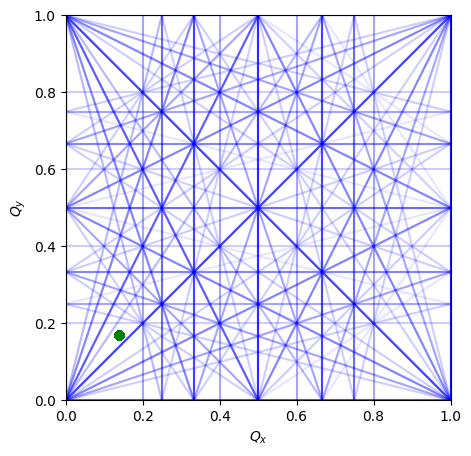

In [106]:
# From R. Tomas
# http://cas.web.cern.ch/sites/cas.web.cern.ch/files/lectures/thessaloniki-2018/slidesbeamer.pdf
from matplotlib import pyplot as plt
def Farey (n):
    '''Return the n-th Farey sequence, ascending.''' 
    seq = [[0 , 1]]
    a, b, c, d = 0, 1, 1, n
    while c <= n:
        k = int( (n + b)/d )
        a, b, c, d = c, d, k*c-a, k*d-b
        seq.append([a , b])
    return seq

def plotTuneDiagram(order = 6):
    fig=plt.figure(figsize=(5,5))
    ax=plt.axes()
    plt.ylim((0,1))
    plt.xlim((0,1))
    x=np.linspace(0,1,1000)
    for i in range(1,order):
        FN=Farey(i) 
        for f in FN:
            h,k=f #Node h/k on the axes
            for sf in FN:
                p,q=sf
                c=float(p*h)
                a=float(k*p) #ResonancelineaQx+bQy=clinkedtop/q
                b=float(q-k*p)
                if a>0:
                    plt.plot(x,c/a-x*b/a,'b',alpha=.1)
                    plt.plot(x,c/a+x*b/a,'b',alpha=.1)
                    plt.plot(c/a-x*b/a,x,'b',alpha=.1)
                    plt.plot(c/a+x*b/a,x,'b',alpha=.1)
                    plt.plot(c/a-x*b/a,1-x,'b',alpha=.1)
                    plt.plot(c/a+x*b/a,1-x,'b',alpha=.1)
                if q==k and p==1: #FNelementsbelow1/k
                    break

    plt.axis('square')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('$Q_x$')
    plt.ylabel('$Q_y$');

plotTuneDiagram()
plt.plot(qx-np.floor(qx), qy-np.floor(qy), 'og')

Let us start assuming simple on-momentum tune shift and considering two Q-trim quadrupole in $s_1$ and $s_2$. Then the linear response of tune correction $(\Delta Q_x,~\Delta Q_y)^T$ with respect to the quadrupole integrated gradients $(k1l(s_1),~k1l(s_2))^T$ is 

\begin{equation}
\begin{pmatrix}
\Delta Q_x \\ 
\Delta Q_y
\end{pmatrix}=\underbrace{\frac{1}{4\pi}
\begin{pmatrix}
\beta_x(s_1) & \beta_x(s_2)   \\ 
-\beta_y(s_1) & -\beta_y(s_2) 
\end{pmatrix}}_{R_{k1l\rightarrow\Delta Q}}
\begin{pmatrix}
k1l(s_1) \\ 
k1l(s_2)
\end{pmatrix}.
\end{equation}

By inverting this problem we can compute the integrated gradient needed (the currents in the trim quadrupoles). I assume a target of Q1=6.14 and Q2=6.17.

In [31]:
import numpy as np
qx_target=6.14
qy_target=6.17
delta_qx=qx_target-twiss_before_correction.qx
delta_qy=qy_target-twiss_before_correction.qy
bx1=twiss_before_correction['betx','qf.1.cell0']
by1=twiss_before_correction['bety','qf.1.cell0']
bx2=twiss_before_correction['betx','qd.2.cell0']
by2=twiss_before_correction['bety','qd.2.cell0']

####### Solution of the linear problem #######
M=np.array([[bx1, bx2],[-by1, -by2]])/4./np.pi
mySolution=np.linalg.inv(M)@np.array([[delta_qx],[delta_qy]])
print('=======================================')
print('This is the solution our matrix of the\nintegrated quadrupole strength:')
display(mySolution)
print('=======================================')
# Clearly it has to be divided by the number of the cells, since the correction it is applied not in for lattice cell
# but in all.

This is the solution our matrix of the
integrated quadrupole strength:


array([[ 0.01601112],
       [-0.07325538]])

In [32]:
# implementing in Xsuite the found solution
env['trim_kf'] =  mySolution[0,0]/l_quad_m/ncell
env['trim_kd'] =  mySolution[1,0]/l_quad_m/ncell
twiss_after_correction = ring.twiss()
print(twiss_after_correction.qx)
print(twiss_after_correction.qy)


6.139350594147268
6.167685759849771


**Comments**: the correction is very close to the target.

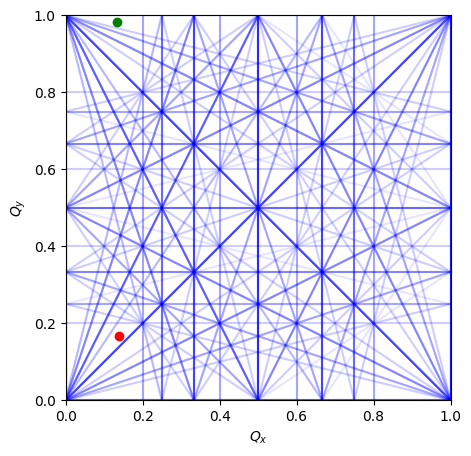

In [33]:
plotTuneDiagram()
qx=twiss_before_correction.qx
qy=twiss_before_correction.qy
plt.plot(qx-np.floor(qx), qy-np.floor(qy), 'og')
qx=twiss_after_correction.qx
qy=twiss_after_correction.qy
plt.plot(qx-np.floor(qx), qy-np.floor(qy), 'or')

## Checking that the new tunes make the V/H plane symmetric (and better)

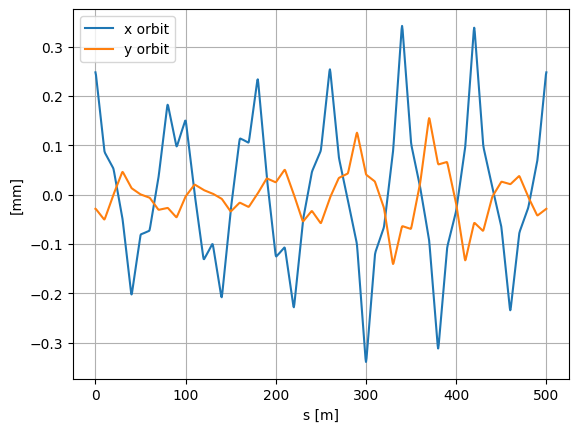

In [44]:
rgen = np.random.RandomState() # fix seed for random number generator

shift_x = rgen.randn(len(tt_quad)) * 0.01e-3 # 0.01 mm rms shift on all quads
shift_y = rgen.randn(len(tt_quad)) * 0.01e-3 # 0.01 mm rms shift on all quads
shift_z = rgen.randn(len(tt_quad)) * 0
for nn_quad, sx, sy, sz in zip(tt_quad.name, shift_x, shift_y, shift_z):
    ring.element_refs[nn_quad].shift_x = sx
    ring.element_refs[nn_quad].shift_y = sy
    ring.element_refs[nn_quad].shift_z = sz

my_twiss = ring.twiss()
plt.plot(my_twiss.s,my_twiss.x*1e3, label = 'x orbit')
plt.plot(my_twiss.s,my_twiss.y*1e3, label = 'y orbit')
plt.ylabel('[mm]')
plt.xlabel('s [m]')
plt.legend()
plt.grid()

for nn_quad, sx, sy, sz in zip(tt_quad.name, shift_x, shift_y, shift_z):
    ring.element_refs[nn_quad].shift_x = 0
    ring.element_refs[nn_quad].shift_y = 0
    ring.element_refs[nn_quad].shift_z = 0

### $\beta$-beating from Q-correction
We could not be exaclty on the target tunes since the model on which we based the correction formula is perturbative. It does not take into account the $\beta$-beating induced by the trim quadrupoles. 

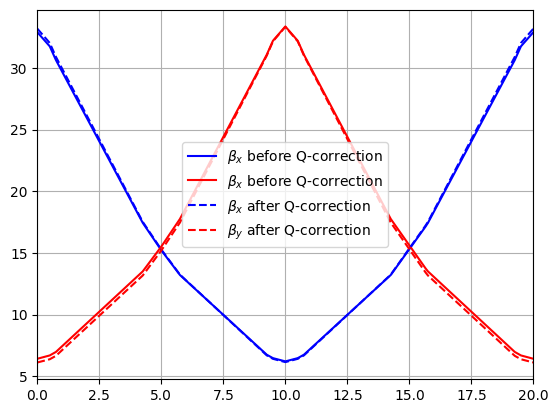

In [45]:
plt.close()
plt.plot(twiss_before_correction['s'],twiss_before_correction['betx'],'b-', label='$\\beta_x$ before Q-correction')
plt.plot(twiss_before_correction['s'],twiss_before_correction['bety'],'r-', label='$\\beta_x$ before Q-correction')
plt.plot(twiss_after_correction['s'],twiss_after_correction['betx'],'b--', label='$\\beta_x$ after Q-correction')
plt.plot(twiss_after_correction['s'],twiss_after_correction['bety'],'r--', label='$\\beta_y$ after Q-correction')
plt.legend(loc='best')
plt.xlim([0, lcell_m ])
plt.grid()

For this reason the final tune is not (exactly) the programmed one. To refine the tune values we can match them with xsuite direclty.

In [46]:
opt = ring.match(
    vary=[
        xt.VaryList(['trim_kf','trim_kd'], step=1e-8, tag='quad'),
    ],
    targets = [
        xt.TargetSet(qx=qx_target, qy=qy_target, tol=1e-10, tag='tune'),
    ])

my_twiss = ring.twiss()

print(f'qx: {my_twiss.qx}')
print(f'qy: {my_twiss.qy}')

Matching: model call n. 8               

qx: 6.1400000000271895
qy: 6.170000000000002


Indeed with Xsuite the correction is much more accurate (**Q1=6.14** and **Q2=6.17**).

### Can you determing by a numerical experiment (tracking) the machine tune?
Clearly yes, thanks to frequency analysis of the phase space.

In [56]:
# I cycle the machine on rf.cell1
ring.cycle(name_first_element='rf.cell1')

<Line None at 5139352320>

In [57]:
# We track a particle with 0.1 mm offset in the two planes
particles = ring.build_particles(
                        x=1e-3,
                        px=0,
                        y=.5e-3,
                        py=0,
                        zeta=0,
                        delta=0)
n_turns = 130
ring.track(particles, num_turns=n_turns,
              turn_by_turn_monitor=True)

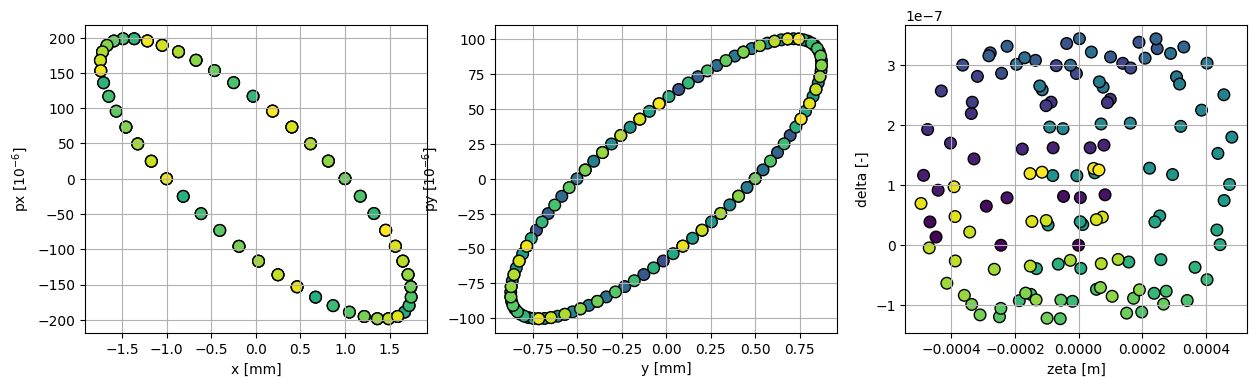

In [58]:
test = ring.record_last_track.copy()

plt.figure(figsize=(15,4))

plt.subplot(131)
plt.scatter(test.x*1000, test.px*1e6,c=np.arange(0,n_turns),s=70, edgecolor='black')
plt.xlabel('x [mm]')
plt.ylabel('px [$10^{-6}$]');
plt.grid()

plt.subplot(132)
plt.scatter(test.y*1000, test.py*1e6,c=np.arange(0,n_turns),s=70, edgecolor='black')
plt.xlabel('y [mm]')
plt.ylabel('py [$10^{-6}$]');
plt.grid()

plt.subplot(133)
plt.scatter(test.zeta, test.delta,c=np.arange(0,n_turns),s=70, edgecolor='black')
plt.xlabel('zeta [m]')
plt.ylabel('delta [-]');
plt.grid()
# myColorbar=plt.colorbar()
# myColorbar.set_label('Turns')
# particle rotate clock-wise in the transverse plane

Indeed one can compute **computing the optics property from the optics phase space**.

One possibility is to use SVD analysis, see more on P. Gonçalves Jorge and X. Buffat, CERN-THESIS-2016-317.

In [59]:
import numpy as np

def getbeta(x, px):
    # P. Gonçalves Jorge and X. Buffat, CERN-THESIS-2016-317.
    # SVD
    U, S, V = np.linalg.svd(np.concat([x, px]))
    N = np.dot(U, np.diag(S))
    
    # Angle of rotation of matrix
    theta = np.arctan(-N[0, 1] / N[0, 0])
    c = np.cos(theta)
    s = np.sin(theta)
    
    # Floquet up to 1/det(USR)
    R = [[c, s], [-s, c]]
    X = np.dot(N, R)
    
    betx = np.abs(X[0, 0] / X[1, 1])
    alfx = X[1, 0] / X[1, 1]
    
    # emit = det(S) / (n / 2)
    J_CS = S[0] * S[1] / (len(x) / 2.0)
    
    return betx, alfx, J_CS

# Easy tracking
# x = np.reshape(np.sqrt(beta * ex) * np.cos(2 * np.pi * Q * np.arange(0, Nturns)), (1, Nturns))
# px = np.reshape(-alpha * x / beta + np.sqrt(ex / beta) * np.sin(2 * np.pi * Q * np.arange(0, Nturns)),  (1, Nturns))
x = test.x
px = test.px
# U, S, V = np.linalg.svd(np.concat([x, px]))

betx, alfx, J_CS = getbeta(x, px)
my_twiss = ring.twiss()

print(f'betx: {betx} (SVD estimated), to be compared with the {my_twiss.betx[0]} from Xsuite.')
print(f'alfx: {alfx} (SVD estimated), to be compared with the {my_twiss.alfx[0]} from Xsuite.')

betx: 15.272067860338561 (SVD estimated), to be compared with the 15.266910142943024 from Xsuite.
alfx: 1.4177238360367843 (SVD estimated), to be compared with the 1.4267343843179043 from Xsuite.


#### Plotting on the normalized phase-space

Remembering that 
\begin{equation}
\bar{P}={\begin{pmatrix}
 \sqrt{\beta} &        0\\
-\frac{\alpha}{\sqrt{\beta}} &  \frac{1}{\sqrt{\beta}}
\end{pmatrix}}
\nonumber
\end{equation}
and that the relation between real phase-space, $X$, and  normalized phase space, $\bar{X}$, is
\begin{equation}
\bar{X}=\bar{P}^{-1} X
\end{equation}
one can transform the previous plots in normalized phase-space.

More in general for the 6x6 case you can use the W matrix from `Xsuite`
\begin{equation}
\bar{X}={W}^{-1} X
\end{equation}


In [65]:
M = np.concat([test.x,test.px, test.y, test.py, test.zeta, test.delta])
normalization = np.linalg.inv(my_twiss.W_matrix[0])@np.concat([test.x,test.px, test.y, test.py, test.zeta, test.delta])

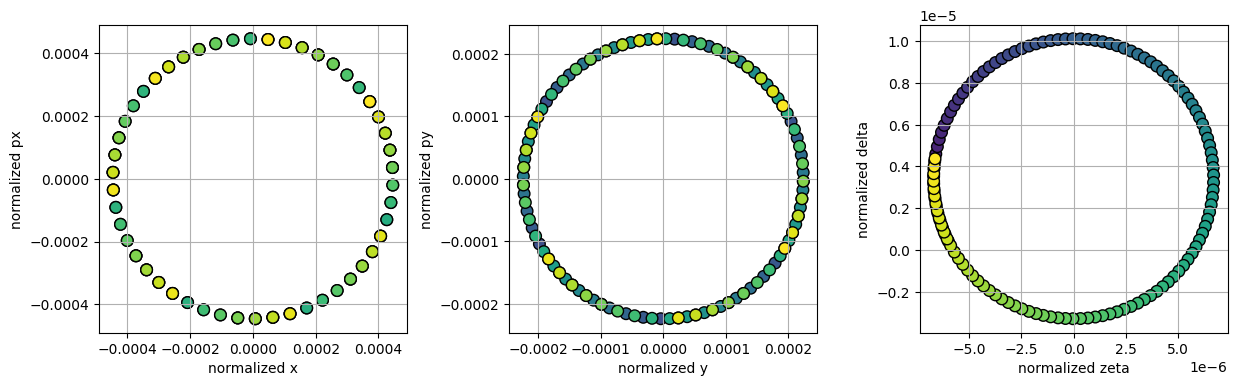

In [66]:
plt.figure(figsize=(15,4))

plt.subplot(131)
plt.scatter(normalization[0,:], normalization[1,:],c=np.arange(0,n_turns),s=70, edgecolor='black')
plt.xlabel('normalized x')
plt.ylabel('normalized px');
plt.axis('square')
plt.grid()

plt.subplot(132)
plt.scatter(normalization[2,:], normalization[3,:],c=np.arange(0,n_turns),s=70, edgecolor='black')
plt.xlabel('normalized y')
plt.ylabel('normalized py');
plt.axis('square')
plt.grid()

plt.subplot(133)
plt.scatter(normalization[4,:], normalization[5,:], c=np.arange(0,n_turns),s=70, edgecolor='black')
plt.xlabel('normalized zeta')
plt.ylabel('normalized delta');
plt.axis('square')
plt.grid()


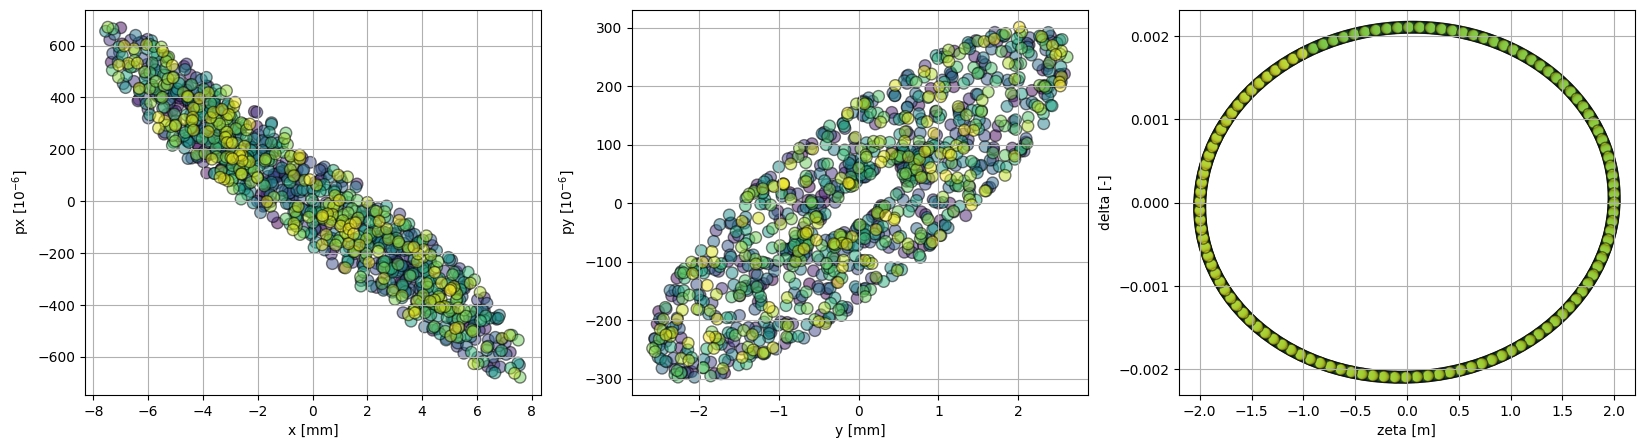

In [67]:
# activating the 
env['k1s_f'] = 0.0005
env['k1s_d'] = 0.0005

particles_2 = ring.build_particles(
                        x=0.001,
                        px=0,
                        y=0.001,
                        py=0,
                        zeta=2, #5,
                        delta=0)

n_turns = 1024
ring.track(particles_2, num_turns=n_turns,
              turn_by_turn_monitor=True)

test =ring.record_last_track

plt.figure(figsize=(20,5))

plt.subplot(131)
plt.scatter(test.x*1000, test.px*1e6,c=np.arange(0,n_turns),s=70, edgecolor='black', alpha =.5)
plt.xlabel('x [mm]')
plt.ylabel('px [$10^{-6}$]');
plt.grid()

plt.subplot(132)
plt.scatter(test.y*1000, test.py*1e6,c=np.arange(0,n_turns),s=70, edgecolor='black', alpha =.5)
plt.xlabel('y [mm]')
plt.ylabel('py [$10^{-6}$]');
plt.grid()

plt.subplot(133)
plt.scatter(test.zeta, test.delta,c=np.arange(0,n_turns),s=70, edgecolor='black', alpha =.5)
plt.xlabel('zeta [m]')
plt.ylabel('delta [-]');
plt.grid()

&#x2753;&#x2753;&#x2753; QUESTION at https://www.menti.com/aluvnsk27yo4

&#x2753;&#x2753;&#x2753; **Can we normalize the phase space above with a W$^{-1}$?**

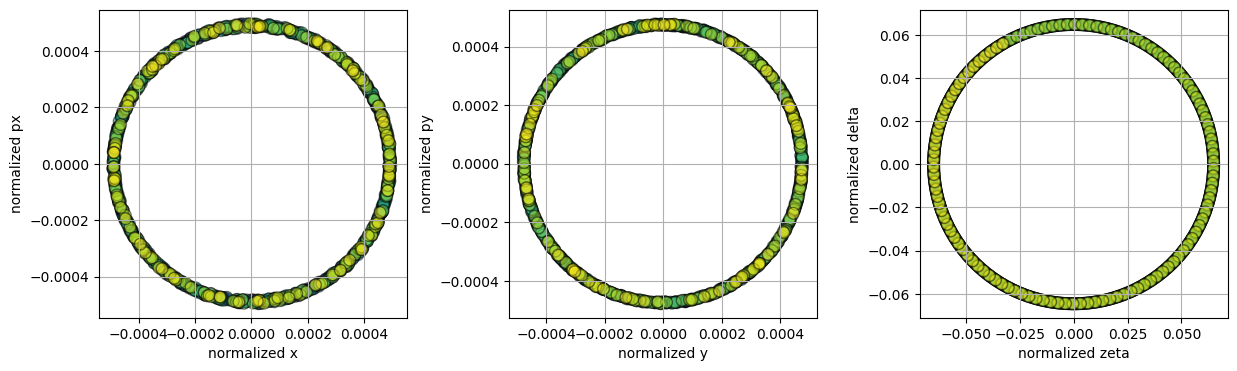

In [70]:
M = np.concat([test.x, test.px, test.y, test.py, test.zeta, test.delta])
my_twiss = ring.twiss()
normalization = np.linalg.inv(my_twiss.W_matrix[0])@np.concat([test.x,test.px, test.y, test.py, test.zeta, test.delta])
plt.figure(figsize=(15,4))

plt.subplot(131)
plt.scatter(normalization[0,:], normalization[1,:],c=np.arange(0,n_turns),s=70, edgecolor='black', alpha =.5)
plt.xlabel('normalized x')
plt.ylabel('normalized px');
plt.axis('square')
plt.grid()

plt.subplot(132)
plt.scatter(normalization[2,:], normalization[3,:],c=np.arange(0,n_turns),s=70, edgecolor='black', alpha =.5)
plt.xlabel('normalized y')
plt.ylabel('normalized py');
plt.axis('square')
plt.grid()

plt.subplot(133)
plt.scatter(normalization[4,:], normalization[5,:], c=np.arange(0,n_turns),s=70, edgecolor='black', alpha =.5)
plt.xlabel('normalized zeta')
plt.ylabel('normalized delta');
plt.axis('square')
plt.grid()


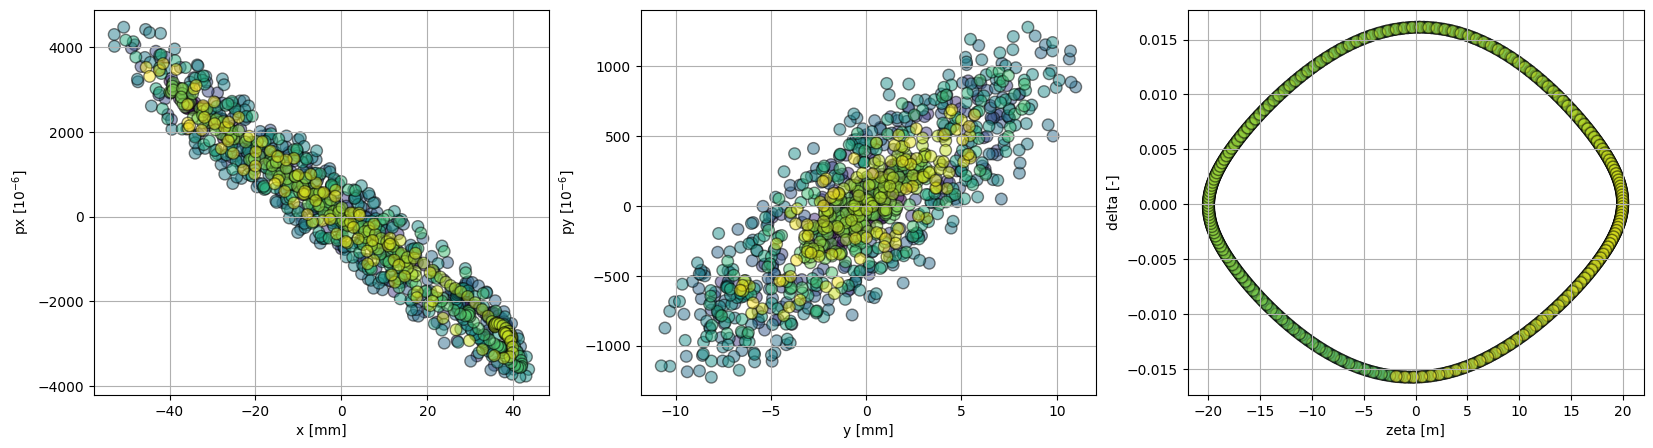

In [71]:
# activating the 
env['k1s_f'] = 0.0005
env['k1s_d'] = 0.0005

particles_2 = ring.build_particles(
                        x=0.001,
                        px=0,
                        y=0.001,
                        py=0,
                        zeta=20, #5,
                        delta=0)

n_turns = 1024
ring.track(particles_2, num_turns=n_turns,
              turn_by_turn_monitor=True)

test =ring.record_last_track

plt.figure(figsize=(20,5))

plt.subplot(131)
plt.scatter(test.x*1000, test.px*1e6,c=np.arange(0,n_turns),s=70, edgecolor='black', alpha =.5)
plt.xlabel('x [mm]')
plt.ylabel('px [$10^{-6}$]');
plt.grid()

plt.subplot(132)
plt.scatter(test.y*1000, test.py*1e6,c=np.arange(0,n_turns),s=70, edgecolor='black', alpha =.5)
plt.xlabel('y [mm]')
plt.ylabel('py [$10^{-6}$]');
plt.grid()

plt.subplot(133)
plt.scatter(test.zeta, test.delta,c=np.arange(0,n_turns),s=70, edgecolor='black', alpha =.5)
plt.xlabel('zeta [m]')
plt.ylabel('delta [-]');
plt.grid()

&#x2753;&#x2753;&#x2753; **Can we still normalize the phase space above with a W$^{-1}$?**

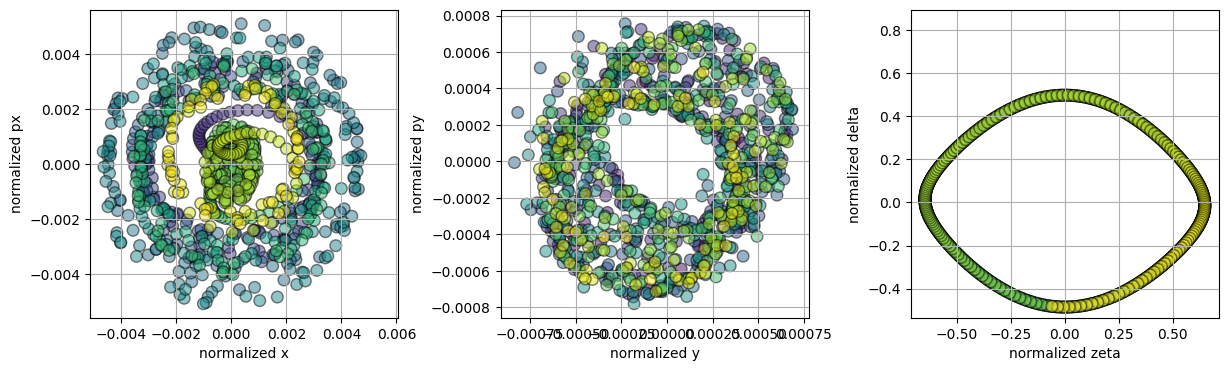

In [314]:
M = np.concat([test.x, test.px, test.y, test.py, test.zeta, test.delta])
my_twiss = ring.twiss()
normalization = np.linalg.inv(my_twiss.W_matrix[0])@np.concat([test.x,test.px, test.y, test.py, test.zeta, test.delta])
plt.figure(figsize=(15,4))

plt.subplot(131)
plt.scatter(normalization[0,:], normalization[1,:],c=np.arange(0,n_turns),s=70, edgecolor='black', alpha =.5)
plt.xlabel('normalized x')
plt.ylabel('normalized px');
plt.axis('square')
plt.grid()

plt.subplot(132)
plt.scatter(normalization[2,:], normalization[3,:],c=np.arange(0,n_turns),s=70, edgecolor='black', alpha =.5)
plt.xlabel('normalized y')
plt.ylabel('normalized py');
plt.axis('square')
plt.grid()

plt.subplot(133)
plt.scatter(normalization[4,:], normalization[5,:], c=np.arange(0,n_turns),s=70, edgecolor='black', alpha =.5)
plt.xlabel('normalized zeta')
plt.ylabel('normalized delta');
plt.axis('square')
plt.grid()


### Tune determination
To determine the tune one can evaluate the maximum of the amplitude of the FFT of x (or px).

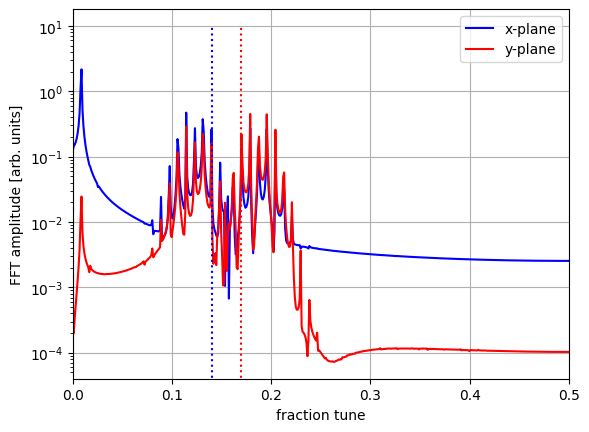

In [76]:

env['k1s_f'] = 0.0005
env['k1s_d'] = 0.0005

particles_2 = ring.build_particles(
                        x=0.001,
                        px=0,
                        y=0.001,
                        py=0,
                        zeta=2, #5,
                        delta=0)

n_turns = 1024
ring.track(particles_2, num_turns=n_turns,
              turn_by_turn_monitor=True)

test =ring.record_last_track

my_x = test.x[0]
my_y = test.y[0]
myAmplitude=np.abs(np.fft.fft(my_x));
myTunes=np.linspace(0,1,len(my_x))
plt.plot(myTunes,myAmplitude,'b',label='x-plane')
plt.xlim([0,0.5])
plt.grid()
myAmplitude=np.abs(np.fft.fft(my_y));
myTunes=np.linspace(0,1,len(my_y))
plt.semilogy(myTunes,myAmplitude,'r',label='y-plane')
plt.plot([qx_target-np.round(qx_target),qx_target-np.round(qx_target)],[-10,10],':b')
plt.plot([qy_target-np.round(qy_target),qy_target-np.round(qy_target)],[-10,10],':r')
plt.ylabel('FFT amplitude [arb. units]')
plt.xlabel('fraction tune')
plt.legend(loc='best');


## Ptolemaic epicycles
<img src="https://upload.wikimedia.org/wikipedia/commons/0/0e/Cassini_apparent.jpg" width="400">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/Epicycle_and_deferent.svg/2560px-Epicycle_and_deferent.svg.png" width="400">


In general we can profit, in our frequency analysis, of the fact that our system in most of cases presents  well separated harmonic oscillations. These algorithms are based on time (e.g., *NAFF: Icarus 88, Issue 2, 1990*) or frequency interpolations (e.g., *SUSSIX: CERN SL/Note 98-017, 1998*). We are going to use the nafflib package (see https://github.com/xsuite/nafflib) that is implementing the NAFF algorithm in python (credit P. Belanger).

In [77]:
# comparing nafflib with a regular FFT
import nafflib 

In [78]:
t = np.linspace(1, 1024, num=1024, endpoint=True)
signal = my_x
# outputs an array of arrays for each frequency. Each sub-array includes:
# [order of harmonic, frequency, Amplitude, Re{Amplitude}, Im{Amplitude]

myListNAFF=[]
myListFFT=[]
for i in np.arange(20,1025):
    myListNAFF.append(nafflib.tune(signal[0:i]))
    myAmplitude=np.abs(np.fft.fft(signal[0:i]));
    myTunes=np.linspace(0,1,i)
    myListFFT.append(np.min(myTunes[myAmplitude==np.max(myAmplitude)]))

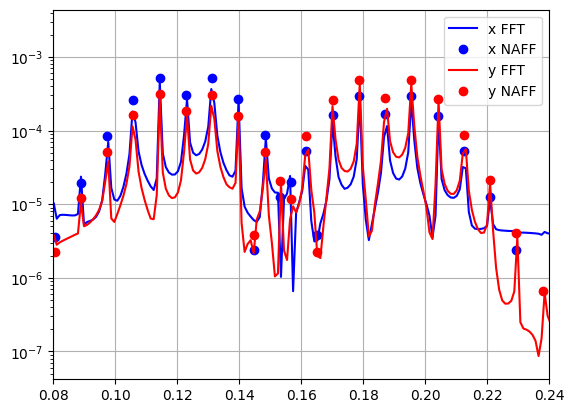

In [79]:
x=test.x[0]
px=test.px[0]
y=test.y[0]
py=test.py[0]

A,Q = nafflib.harmonics(x, px, num_harmonics=50, window_order=2, window_type="hann")
myAmplitude=np.abs(np.fft.fft(x)/1024);
myTunes=np.linspace(0,1,len(x))
plt.semilogy(myTunes,myAmplitude, 'b', label='x FFT')
plt.semilogy(Q,np.abs(A), 'ob', label='x NAFF')

A,Q = nafflib.harmonics(y, py, num_harmonics=50, window_order=2, window_type="hann")
myAmplitude=np.abs(np.fft.fft(y)/1024);
myTunes=np.linspace(0,1,len(y))
plt.semilogy(myTunes,myAmplitude, 'r', label='y FFT')
plt.semilogy(Q,np.abs(A), 'or', label='y NAFF')
plt.xlim(0.08,0.24)
plt.grid()
plt.legend(loc='best')


## Chromaticity
We are going now to study the chromatic propertis of CAS-24 lattice.

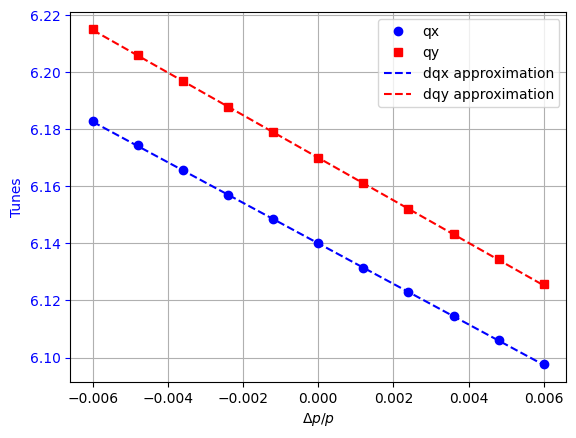

In [80]:

# I cycle the machine on rf.cell1
ring.cycle(name_first_element='qf.1.cell0')


env['k1s_f'] = 0
env['k1s_d'] = 0
env['k2_f'] = 0
env['k2_d'] = 0

my_twiss = ring.twiss()
aux=beamFB['deltap_p']
delta_values = np.linspace(-aux*3, aux*3, 11)

qx_values = []
qy_values = []
betax1_max = []
betay1_max = []
betax2_max = []
betay2_max = []

table_list = [] 

for i, delta in enumerate(delta_values):
    print(f'Xsuite working on {i} of {len(delta_values)}  ', end='\r', flush=True)
    tt = ring.twiss(method='4d', delta0=delta)
    table_list.append(tt)
    qx_values.append(tt.qx) 
    qy_values.append(tt.qy) 
    betax1_max.append(np.max(tt.betx1))
    betay1_max.append(np.max(tt.bety1))
    betax2_max.append(np.max(tt.betx2))
    betay2_max.append(np.max(tt.bety2))


plt.plot(delta_values, qx_values, 'bo', label='qx')
plt.plot(delta_values, qy_values, 'rs', label='qy')

plt.gca().tick_params(axis='y', colors='blue')
plt.ylabel('Tunes', color='blue')
plt.xlabel('$\\Delta p/p$')
plt.plot(delta_values, delta_values*my_twiss.dqx+my_twiss.qx, 'b--', label='dqx approximation')
plt.plot(delta_values, delta_values*my_twiss.dqy+my_twiss.qy, 'r--', label='dqy approximation')

plt.ylabel('Tunes')
plt.grid(True)
plt.legend()


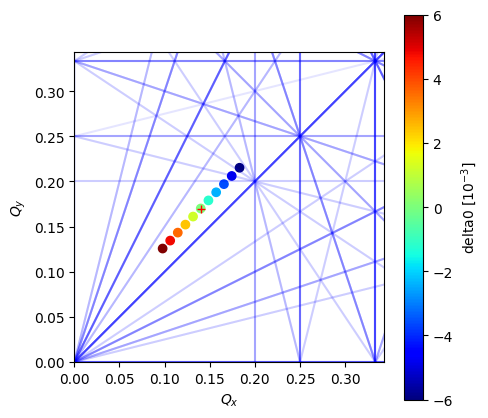

In [82]:
plotTuneDiagram()
Q1=qx_values
Q2=qy_values
plt.scatter(Q1-np.floor(Q1),Q2-np.floor(Q2),c=delta_values*1000, cmap='jet');

Q1=qx_values[5]
Q2=qy_values[5]
plt.plot(Q1-np.floor(Q1),Q2-np.floor(Q2),'+r');

plt.xlim(0,1/3+.01)
plt.ylim(0,1/3+.01)
myColorbar=plt.colorbar()
myColorbar.set_label('delta0 [$10^{-3}$]')

### Off-momentum $\beta$-beating
In addition to the different tunes, the off-momentum particle will be also present a off-momentum $\beta$-beating.

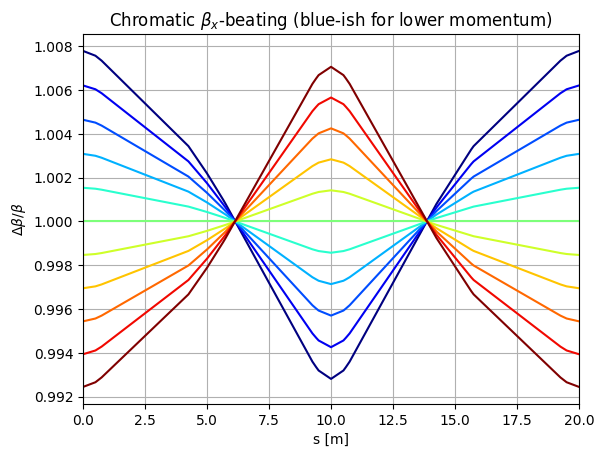

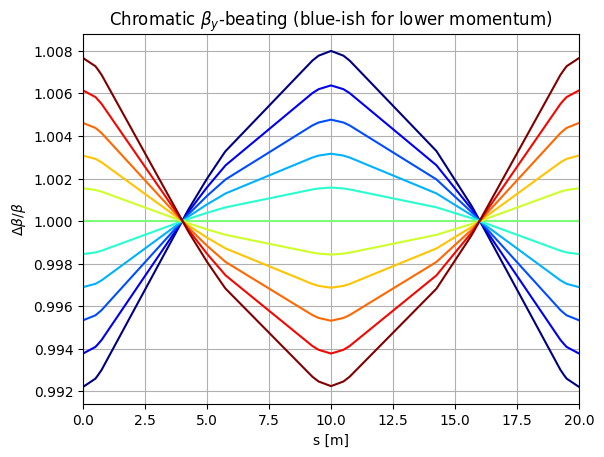

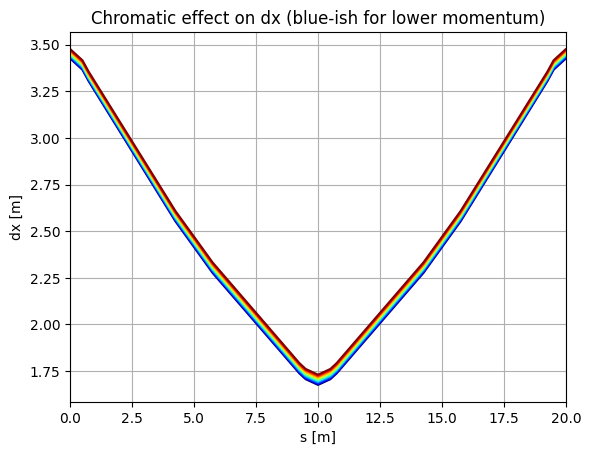

In [83]:
import matplotlib
cmap=matplotlib.colormaps.get_cmap('jet')
colors = cmap(np.linspace(0, 1, 11))
aux2 = table_list[5]
for ii in range(0,11):
    aux1=table_list[ii]
    plt.plot(aux1.s, aux1.betx/aux2.betx,color=colors[ii])
#plt.plot(aux1.s, aux1.betx/aux2.betx,color=myColor(21))
plt.xlim(0,lcell_m)
plt.xlabel('s [m]')
plt.ylabel('$\\Delta \\beta/\\beta$')
plt.title('Chromatic $\\beta_x$-beating (blue-ish for lower momentum)');
plt.grid()


plt.figure()
for ii in range(0,11):
    aux1=table_list[ii]
    plt.plot(aux1.s, aux1.bety/aux2.bety,color=colors[ii])
#plt.plot(aux1.s, aux1.betx/aux2.betx,color=myColor(21))
plt.xlim(0,lcell_m)
plt.xlabel('s [m]')
plt.ylabel('$\\Delta \\beta/\\beta$')
plt.title('Chromatic $\\beta_y$-beating (blue-ish for lower momentum)');
plt.grid()

plt.figure()
for ii in range(0,11):
    aux1=table_list[ii]
    plt.plot(aux1.s, aux1.dx,color=colors[ii])
plt.xlim(0,lcell_m)
plt.xlabel('s [m]')
plt.ylabel('dx [m]')
plt.title('Chromatic effect on dx (blue-ish for lower momentum)');
plt.grid()

## Chromatic correction

Remembering that sextupole acts as quadrupoles on the dispersive closed orbit (feed-down) and assuming
that we have two sextupoles in $s_1$ and $s_2$,  then the linear response of chromaticity $(\Delta\xi_x,~\Delta\xi_y)^T$ with respect to the sextupoles integrated gradients $(k2l(s_1),~k2l(s_2))^T$ is 

\begin{equation}
\begin{pmatrix}
\Delta\xi_x \\ 
\Delta\xi_y
\end{pmatrix}=\underbrace{\frac{1}{4\pi}
\begin{pmatrix}
\beta_x(s_1) D_x(s_1) & \beta_x(s_2) D_x(s_2)  \\ 
-\beta_y(s_1) D_x(s_1) & -\beta_y(s_2) D_x(s_2)
\end{pmatrix}}_{R_{k2l\rightarrow \Delta\xi}}
\begin{pmatrix}
k2l(s_1) \\ 
k2l(s_2)
\end{pmatrix}.
\end{equation}

We can determine the value of $(k2l(s_1),~k2l(s_2))^T$ by inverting this problem after having chosen $s_1$ and $s_2$.

In [84]:
env['k1s_f'] = 0
env['k1s_d'] = 0
env['k2_f'] = 0
env['k2_d'] = 0
my_twiss = ring.twiss()

print(f'dqx: {my_twiss.dqx}')
print(f'dqy: {my_twiss.dqy}')

dqx: -7.098454451011094
dqy: -7.454883396791345


In [85]:
twissSextupolesOFF = my_twiss
dq1=twissSextupolesOFF.dqx/ncell
dq2=twissSextupolesOFF.dqy/ncell

index_sf = 1
index_sd = 13
assert twissSextupolesOFF['name', index_sf] == 'sf.1.cell0'
twissSextupolesOFF['name', index_sf] == 'sd.1.cell0'
bx1 = (twissSextupolesOFF['betx',index_sf] + twissSextupolesOFF['betx',index_sf+1])/2
by1 = (twissSextupolesOFF['bety',index_sf] + twissSextupolesOFF['bety',index_sf+1])/2
dx1 = (twissSextupolesOFF['dx',index_sf] + twissSextupolesOFF['dx',index_sf+1])/2

bx2 = (twissSextupolesOFF['betx',index_sd] + twissSextupolesOFF['betx',index_sd+1])/2
by2 = (twissSextupolesOFF['bety',index_sd] + twissSextupolesOFF['bety',index_sd+1])/2
dx2 = (twissSextupolesOFF['dx',index_sd] + twissSextupolesOFF['dx',index_sd+1])/2

####### Solution of the linear problem #######
M=np.array([[bx1*dx1, bx2*dx2],[-by1*dx1, -by2*dx2]])/4./np.pi
mySolution=np.linalg.inv(M)@np.array([[-dq1],[-dq2]])
print('=======================================')
print('This matrix gives the solution of the\nintegrated sextupole strength:')
display(mySolution)
print('=======================================')
# Clearly it has to be divided (shared) by the number of the cells

This matrix gives the solution of the
integrated sextupole strength:


array([[ 0.04160124],
       [-0.08254298]])

In [86]:
env['k2_f']=mySolution[0][0]/l_sext_m
env['k2_d']=mySolution[1][0]/l_sext_m
twissSextupolesON = ring.twiss()
print(f'dqx: {twissSextupolesON.dqx}')
print(f'dqy: {twissSextupolesON.dqy}')

dqx: -0.05969512045567171
dqy: -0.1354766573236077


In [87]:
# Compare with the matching in Xsuite

env.vars['k2_f'] = 0 #reset coefficients
env.vars['k2_d'] = 0

opt = ring.match(
            vary = [
                xt.VaryList(['k2_f', 'k2_d'], step=1e-6),
            ],
            targets = [
                xt.TargetSet(dqx=0, dqy=0, tol=1e-5)
            ]
    )

opt.log()
opt.target_status()
my_twiss = ring.twiss()

print(f'dqx: {my_twiss.dqx}')
print(f'dqy: {my_twiss.dqy}')

Matching: model call n. 20               

Target status:                           
id state tag tol_met       residue   current_val target_val description                      
0  ON           True   -2.4165e-06   -2.4165e-06          0 'dqx', val=0, tol=1e-05, weight=1
1  ON           True   1.06581e-10   1.06581e-10          0 'dqy', val=0, tol=1e-05, weight=1
dqx: -2.4165025536149187e-06
dqy: 1.0658141036401503e-10


The second order chromaticity is not corrected.

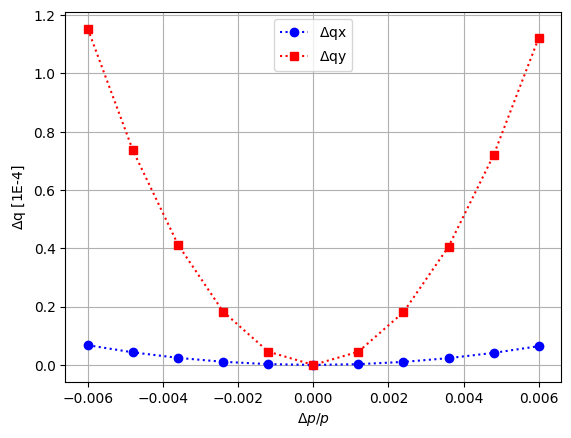

In [89]:
my_twiss = ring.twiss()
aux=beamFB['deltap_p']
delta_values = np.linspace(-aux*3, aux*3, 11)

qx_values = []
qy_values = []
betax1_max = []
betay1_max = []
betax2_max = []
betay2_max = []

table_list = [] 

for i, delta in enumerate(delta_values):
    print(f'Xsuite working on {i} of {len(delta_values)}  ', end='\r', flush=True)
    tt = ring.twiss(method='4d', delta0=delta)
    table_list.append(tt)
    qx_values.append(tt.qx) 
    qy_values.append(tt.qy) 
    betax1_max.append(np.max(tt.betx1))
    betay1_max.append(np.max(tt.bety1))
    betax2_max.append(np.max(tt.betx2))
    betay2_max.append(np.max(tt.bety2))


plt.plot(delta_values, (qx_values-qx_values[5])*1e4, 'bo:', label='$\\Delta$qx')
plt.plot(delta_values, (qy_values-qy_values[5])*1e4, 'rs:', label='$\\Delta$qy')

plt.xlabel('$\\Delta p/p$')
plt.ylabel('$\\Delta$q [1E-4]')
plt.grid(True)
plt.legend()

The chromaticity reduction improved significantly also the chromatic $\beta$-beating. In fact,

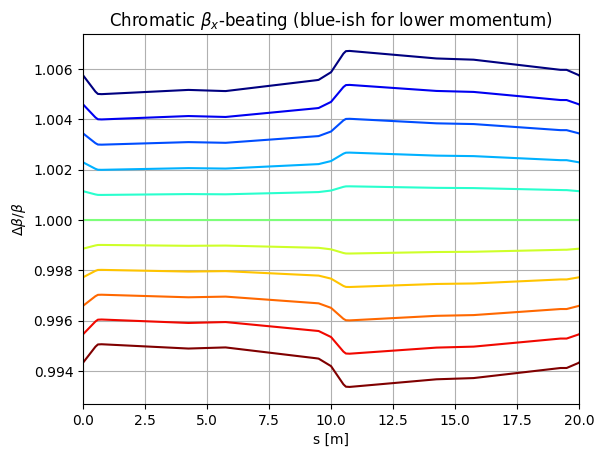

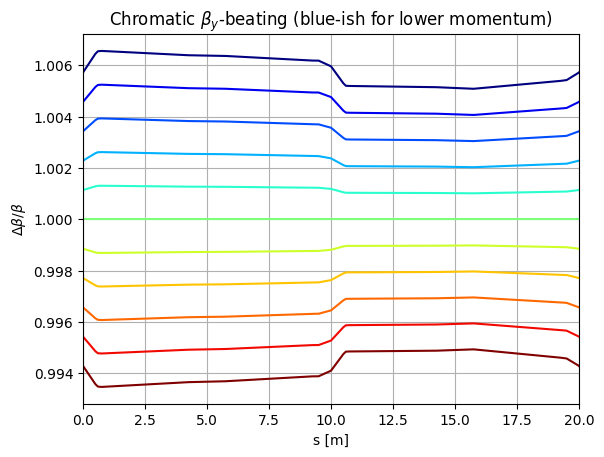

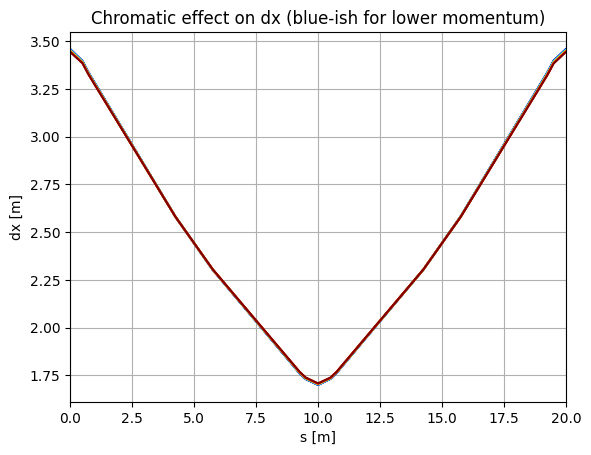

In [90]:
import matplotlib
cmap=matplotlib.colormaps.get_cmap('jet')
colors = cmap(np.linspace(0, 1, 11))
aux2 = table_list[5]
for ii in range(0,11):
    aux1=table_list[ii]
    plt.plot(aux1.s, aux1.betx/aux2.betx,color=colors[ii])
#plt.plot(aux1.s, aux1.betx/aux2.betx,color=myColor(21))
plt.xlim(0,lcell_m)
plt.xlabel('s [m]')
plt.ylabel('$\\Delta \\beta/\\beta$')
plt.title('Chromatic $\\beta_x$-beating (blue-ish for lower momentum)');
plt.grid()


plt.figure()
for ii in range(0,11):
    aux1=table_list[ii]
    plt.plot(aux1.s, aux1.bety/aux2.bety,color=colors[ii])
#plt.plot(aux1.s, aux1.betx/aux2.betx,color=myColor(21))
plt.xlim(0,lcell_m)
plt.xlabel('s [m]')
plt.ylabel('$\\Delta \\beta/\\beta$')
plt.title('Chromatic $\\beta_y$-beating (blue-ish for lower momentum)');
plt.grid()

plt.figure()
for ii in range(0,11):
    aux1=table_list[ii]
    plt.plot(aux1.s, aux1.dx,color=colors[ii])
plt.xlim(0,lcell_m)
plt.xlabel('s [m]')
plt.ylabel('dx [m]')
plt.title('Chromatic effect on dx (blue-ish for lower momentum)');
plt.grid()

Therefore if we plot again the Q-diagram, after the chromaticity correction, we have the following result:

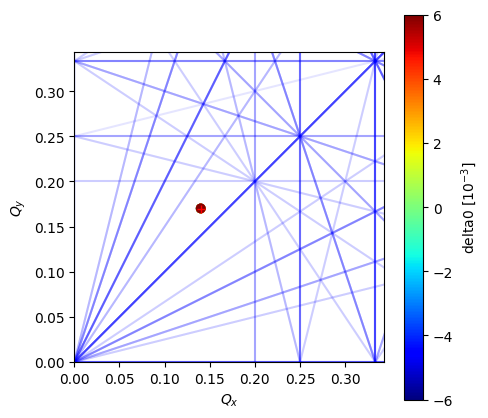

In [91]:
plotTuneDiagram()
Q1=qx_values
Q2=qy_values
plt.scatter(Q1-np.floor(Q1),Q2-np.floor(Q2),c=delta_values*1000, cmap='jet');

Q1=qx_values[5]
Q2=qy_values[5]
plt.plot(Q1-np.floor(Q1),Q2-np.floor(Q2),'+r');

plt.xlim(0,1/3+.01)
plt.ylim(0,1/3+.01)
myColorbar=plt.colorbar()
myColorbar.set_label('delta0 [$10^{-3}$]')

### But now the system is NOT linear anymore...
We trade-off the off-momentum detuning with some amplitude detuning (chromatic vs geometrical distorsion). To explore the amplitude detuning we compute the so-called tune fooprint.

Tracking particles for footprint...
Done tracking.
Done computing footprint.


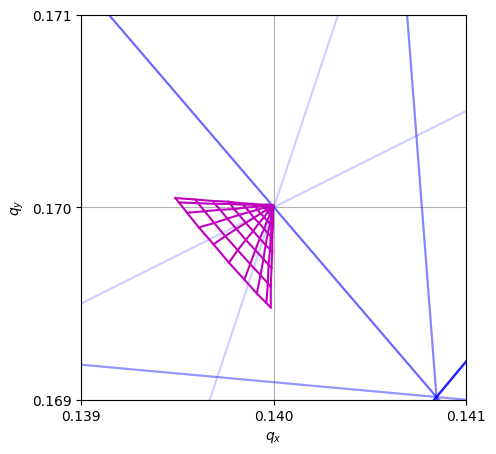

In [116]:
fp0 = ring.get_footprint(nemitt_x=nemitt_x, nemitt_y=nemitt_y)
plotTuneDiagram(order=17)
fp0.plot(color='m')
plt.axis('square')
plt.xlim(0.139, .141)
plt.ylim(0.169, .171)
plt.xticks([0.139,.140,.141])
plt.yticks([0.169,.170,.171]);
plt.grid(True)

These are the initial condition of the tracked particles for determing  the tune footprint.

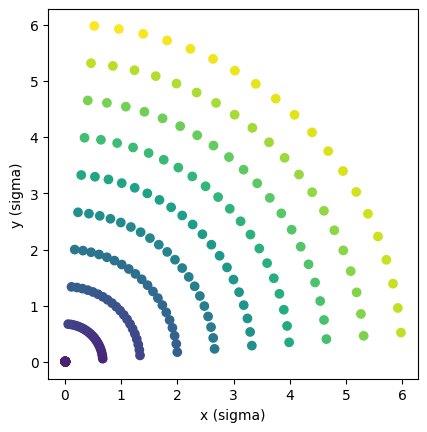

In [118]:
import xpart as xp
env['k3_f'] = 0
env['k3_d'] = 0
n_r = 10
n_theta = 20

x_normalized, y_normalized, r_xy, theta_xy = xp.generate_2D_polar_grid(
    r_range=(0.01, 6.), 
    theta_range=(np.deg2rad(5), np.deg2rad(85)),
    nr=n_r, ntheta=n_theta)

n_part = len(x_normalized)

particles_3 = ring.build_particles(
    x_norm=x_normalized, px_norm=0,
    y_norm=y_normalized, py_norm=0,
    nemitt_x=nemitt_x, nemitt_y=nemitt_y, # normalized emittances
    delta=0, method="4d")

mytwiss = ring.twiss4d()
ring.track(particles_3, num_turns=1024, turn_by_turn_monitor=True)

plt.figure()
plt.scatter(x_normalized, y_normalized, c=ring.record_last_track.particle_id[:, 0])
plt.xlabel("x (sigma)")
plt.ylabel("y (sigma)")
plt.axis('square');

<Figure size 640x480 with 0 Axes>

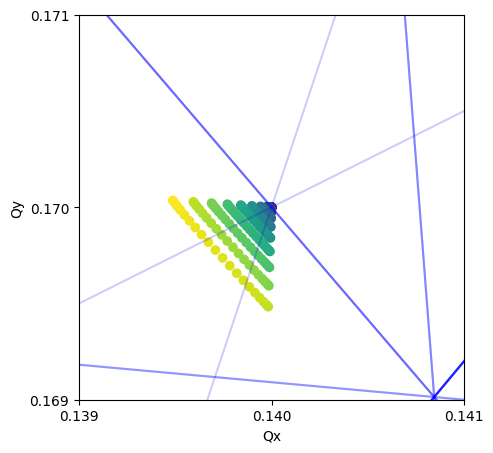

In [119]:
import nafflib
qx = [nafflib.tune(ring.record_last_track.x[i, :]) for i in range(n_part)]
qy = [nafflib.tune(ring.record_last_track.y[i, :]) for i in range(n_part)]

plt.figure()
plotTuneDiagram(order=17)

plt.scatter(qx, qy,  c=ring.record_last_track.particle_id[:, 0])
plt.xlabel("Qx")
plt.ylabel("Qy")
plt.axis('square')
plt.xlim(0.139, .141)
plt.ylim(0.169, .171)
plt.xticks([0.139,.140,.141])
plt.yticks([0.169,.170,.171]);

In [ ]:
env['k3_f']=-10
env['k3_d']=20

fp0 = ring.get_footprint(nemitt_x=nemitt_x, nemitt_y=nemitt_y)

(0.15, 0.18)

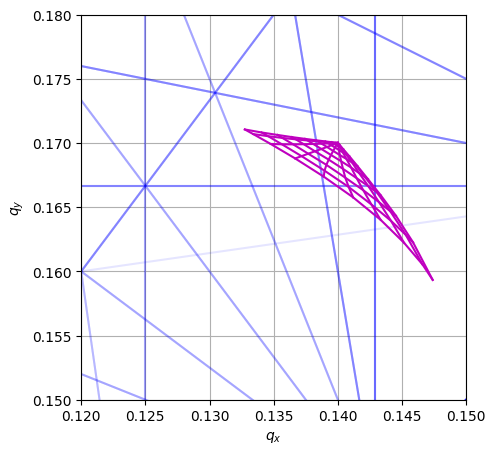

In [126]:
plotTuneDiagram(9)
fp0.plot(color='m')
plt.axis('square')
plt.grid(True)
plt.axis('square')
plt.xlim(0.12, .15)
plt.ylim(0.15, .18)
# plt.xticks([0.139,.140,.141])
# plt.yticks([0.169,.170,.171]);

### Extracting second order maps from Xsuite


In [127]:
ring.cycle(name_first_element = 'start_cell.cell0')

<Line None at 5139352320>

In [128]:
aux = ring.get_line_with_second_order_maps(split_at=['start_cell.cell0', '_end_point'])
aux.get_table()

Table: 4 rows, 8 cols
name                         s element_type         isthick isreplica parent_name iscollective ...
start_cell.cell0             0 Marker                 False     False None               False
map_0                        0 SecondOrderTaylorMap    True     False None               False
end_cell.cell24            500 Marker                 False     False None               False
_end_point                 500                        False     False None               False

In the previous dataframe you can see for the different elements the maps 
\begin{equation}
\boxed{
x_i(s_1)=\underbrace{k_i}_{0-order}+ \underbrace{\sum_j r_{ij}\ x_j(s_0)}_{1-order} + \underbrace{\sum_j\sum_k t_{ijk}\ x_j(s_0)x_k(s_0)}_{2-order}
}
\end{equation}
where $k_i$,$r_{ij}$ and $t_{ijk}$ can be found in the **sectormap** dataframe. The $x_i$ are the 6 phase coordinates (in MAD-X are (x,px,y,py,t,pt)) in $s_0$ and $s_1$.

In [129]:
import pandas as pd
pd.DataFrame(aux['map_0'].k)

0
0 -2.731126e-12
1 -1.751801e-13
2  0.000000e+00
3  0.000000e+00
4 -4.687803e-10
5  1.355435e-15

In [130]:
pd.DataFrame(aux['map_0'].R)

0          1         2         3         4          5
0  0.637444  25.560825  0.000000  0.000000 -0.000109   1.251341
1 -0.023227   0.637404  0.000000  0.000000  0.000006   0.080199
2  0.000000   0.000000  0.481754  5.362333  0.000000   0.000000
3  0.000000   0.000000 -0.143205  0.481754  0.000000   0.000000
4 -0.079912  -1.237897  0.000000  0.000000  0.997309  50.990230
5  0.000006   0.000287  0.000000  0.000000 -0.000056   0.999839

In [131]:
pd.DataFrame(aux['map_0'].R)

0          1         2         3         4          5
0  0.637444  25.560825  0.000000  0.000000 -0.000109   1.251341
1 -0.023227   0.637404  0.000000  0.000000  0.000006   0.080199
2  0.000000   0.000000  0.481754  5.362333  0.000000   0.000000
3  0.000000   0.000000 -0.143205  0.481754  0.000000   0.000000
4 -0.079912  -1.237897  0.000000  0.000000  0.997309  50.990230
5  0.000006   0.000287  0.000000  0.000000 -0.000056   0.999839

In [132]:
aux['map_0'].T[0,0,1]

np.float64(5.999410780110903)

For this thin sextupole and for the x-plane, that 
\begin{eqnarray}
x_1&=&x_0\\
px_1&=&px_0+ g\times (x_0^2 - y_0^2)
\end{eqnarray}
where the indexes 0 and 1 refer, respectively, to the entry and exit of the sextupole (it is thin since $x_1=x_0$).

This is one of the simplest non-linear map we can image. Its systematic study has been carried out by [Michel Hénon](https://en.wikipedia.org/wiki/Michel_H%C3%A9non) (1931-2013). The simplest version of the Hénon map assumes 1D motion and decomposes the motion of the particle in a pure rotation and a thin sextupolar kick 
\begin{equation}
\begin{pmatrix}
x_{n+1}\\
px_{n+1}
\end{pmatrix}
=
\begin{pmatrix}
\cos\mu_x\quad \sin\mu_x\\
-\sin\mu_x\quad \cos\mu_x
\end{pmatrix}
\begin{pmatrix}
x_{n}\\
px_{n}
\end{pmatrix}+
g\begin{pmatrix}
0\\
x_n^2
\end{pmatrix}
\end{equation}

In [133]:
from ipywidgets import interactive
import warnings
warnings.filterwarnings('ignore')
# Q is the tune
# a and phi0 are the max amplitude and the phase of the turn=0 points
# Nturns is the turn number
# g is proportional to the sextupole gradient
# the code solve the simple Hénon map
# x[n+1] = x[n]
# xp[n+1]= xp[n]+g*x[n]^2
# and after I apply a pure rotation of Q
Q=1/4+.001
a=.05
Nturns=1000
Namplitude=20
g=-23


def henonMap(Q, phi0,a,g,Nturns,Namplitude):
    phi_rad=np.pi/180.*phi0
    phi=2*np.pi*Q
    R=np.array([[np.cos(phi),np.sin(phi)],[-np.sin(phi),np.cos(phi)]])
    R0=np.array([[np.cos(phi_rad),np.sin(phi_rad)],[-np.sin(phi_rad),np.cos(phi_rad)]])
    particle = []
    for j in np.linspace(0,a,Namplitude): 
        X=np.zeros([Nturns,2])
        A=R0 @ np.array([[j],[0]])
        X[0,:]=A.transpose()[0]
        for i in range(Nturns-1):
            #X.append(R @ (X[i]+g*np.array([[0],[X[i][0]*X[i][0]]])))
            X[i+1,:] = (R @ (X[i,:]+g*np.array([0,X[i,0]*X[i,0]])))
        particle.append(X)
    for X in particle:
        plt.plot(np.array(X)[:,0],np.array(X)[:,1],'.', ms=1)
        plt.axis('square');
        plt.xlabel('$\\bar{x}$ [$\\sqrt{m}$]')
        plt.ylabel('$\\bar{px}$ [$\\sqrt{m}$]')
        plt.xlim(-a,a)
        plt.ylim(-a,a);
        plt.title('Q='+str(Q)+
                  ', phi0='+str(phi0)+
                  ', a='+str(a)+
                  ', g='+str(g))
interactive_plot = interactive(henonMap, Q=(0.0, 1.0, 0.001), phi0=(0, 360, 1), a=(0, .1, .0001),g=(-50,50,1),Nturns=(0,2000,1),Namplitude=(10,50,1),continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.5, description='Q', max=1.0, step=0.001), IntSlider(value=180, descr…

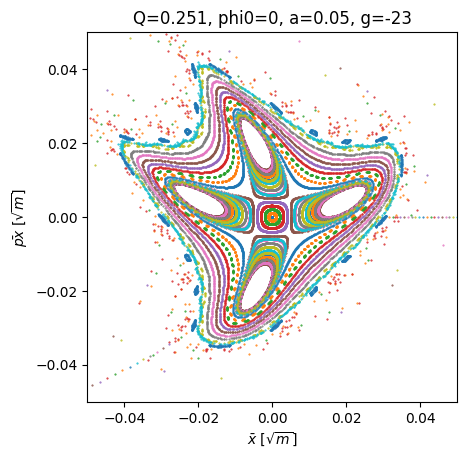

In [134]:
# An example
henonMap(Q=1/4+.001, phi0=0,a=.05,g=-23,Nturns=1000,Namplitude=50)

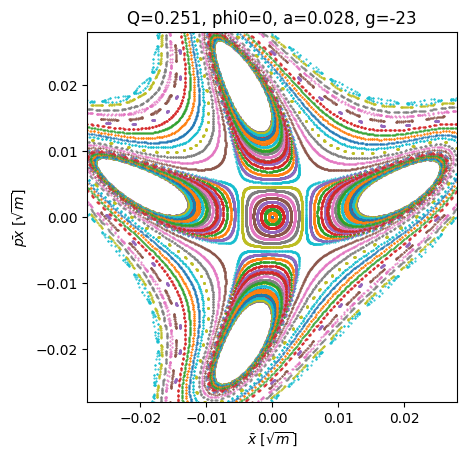

In [135]:
# An example
henonMap(Q=1/4+.001, phi0=0, a=.028,g=-23,Nturns=1000,Namplitude=50)

### Dynamic aperture
Can define a scalar observable to take into accound the evolotion of this phase portrait? Indeed several observables can be defined. We will concentrate on the evolution of $(\bar{x}^2+\bar{px}^2)/2$.

In [143]:
import pandas as pd
Q=1/4+.001
a=.028
Nturns=1000
Namplitude=50
g=-23
phi0=0
def DAStudies(Q, phi0,a,g,Nturns,Namplitude):
    aux=pd.DataFrame()
    phi_rad=np.pi/180.*phi0
    
    phi=2*np.pi*Q

    R=np.array([[np.cos(phi),np.sin(phi)],[-np.sin(phi),np.cos(phi)]])
    R0=np.array([[np.cos(phi_rad),np.sin(phi_rad)],[-np.sin(phi_rad),np.cos(phi_rad)]])

    for j in np.linspace(0,a,Namplitude): 
        X=[]
        Amplitude=[]
        A=R0 @ np.array([j,0])
        X.append(A)
        Amplitude.append((A[0]**2+A[1]**2)/2)
        for i in range(Nturns):
            X.append(R @ (X[i]+g*np.array([0,X[i][0]*X[i][0]])))
            Amplitude.append((X[i+1][0]**2+X[i+1][1]**2)/2)
        aux=pd.concat([aux,pd.DataFrame(np.array(Amplitude),columns=[j])], axis=1, sort=False)

    return aux
aux=DAStudies(Q, phi0,a,g,Nturns,Namplitude)

In [144]:
def DAStudiesVsTurns(Nturns):
    plt.loglog(aux.loc[0].values,aux[0:Nturns].max(),'ok')
    plt.ylim(0.0000001,.015)
    plt.xlim(0.0000001,.015)
    plt.grid()
    plt.xlabel('$J_H(0)$ [m]') 
    plt.ylabel('$\max_{turns}\ \ J_H $ [m]')

interactive_plot = interactive(DAStudiesVsTurns,Nturns=(1,2000,1),continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=1000, description='Nturns', max=2000, min=1), Output(layout=Layout(heigh…

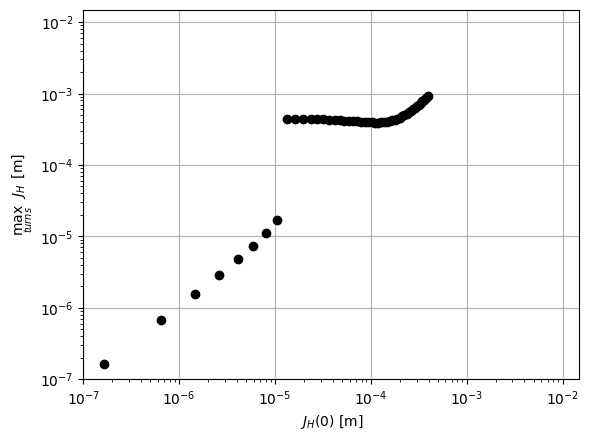

In [145]:
# An example
DAStudiesVsTurns(1000)

## Frequency locking mechanism
We can also study the frequency of the single particles and consider as function of the initial amplitude.

In [146]:
Q=1/4+.001
a=.028
Nturns=5000
Namplitude=50
g=-23
def amplitudeDetuning(Q, phi0,a,g,Nturns,Namplitude):
    aux=pd.DataFrame()
    phi_rad=np.pi/180.*phi0   
    phi=2*np.pi*Q
    R=np.array([[np.cos(phi),np.sin(phi)],[-np.sin(phi),np.cos(phi)]])
    R0=np.array([[np.cos(phi_rad),np.sin(phi_rad)],[-np.sin(phi_rad),np.cos(phi_rad)]])
    for j in np.linspace(0,a,Namplitude): 
        X=[]
        Amplitude=[]
        A=R0 @ np.array([j,0])
        X.append(A)
        Amplitude.append(np.sqrt(A[0]**2+A[1]**2)/2)
        for i in range(Nturns):
            X.append(R @ (X[i]+g*np.array([0,X[i][0]*X[i][0]])))
            Amplitude.append(X[i+1][0])
        aux=pd.concat([aux,pd.DataFrame(np.array(Amplitude),columns=[j])], axis=1, sort=False)
    return aux
aux=amplitudeDetuning(Q, 0,a,g,Nturns,Namplitude)

import nafflib


myQ=[]
for i in range(Namplitude)[1:]:
    signal = aux[aux.columns[i]].values;
    
    # outputs an array of arrays for each frequency. Each sub-array includes:
    # [order of harmonic, frequency, Amplitude, Re{Amplitude}, Im{Amplitude]

    # My frequency is simply 
    myQ.append(nafflib.tune(signal))

In [147]:
def amplitudeDetuningVsTurns(Nturns):
    myQ=[]
    for i in range(Namplitude)[1:]:
        signal = aux[aux.columns[i]].values;
        myQ.append(nafflib.tune(signal[0:Nturns]))
    plt.semilogx(np.linspace(0,a,Namplitude)[1:]**2/2,myQ,'k.-')
    myX=np.linspace(0,a,Namplitude)[1:]
    plt.plot(myX**2/2,Q*np.ones_like(myX),'-.r')
    plt.grid()
    plt.xlim(0,0.0005)
    plt.ylabel('$Q_x$')
    plt.xlabel('$\\bar{x}_0$ [$\sqrt{m}$]')

interactive_plot = interactive(amplitudeDetuningVsTurns,Nturns=(100,5000,1),continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot


interactive(children=(IntSlider(value=2550, description='Nturns', max=5000, min=100), Output(layout=Layout(hei…

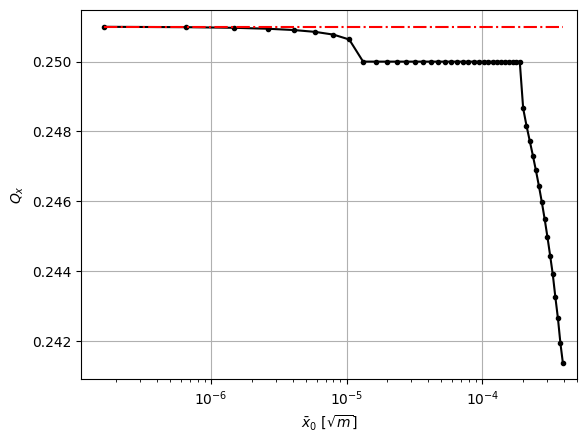

In [148]:
# An example
amplitudeDetuningVsTurns(2500)

## Optimizing the tune (maximize the DA)
We can ask ourself what is the optimal tune to avoid the stronger resonance. We can define a scalar observable to "express" the beam lifetime.

In [149]:
DA_mm_at1000=[]
myQRange=np.linspace(0.02,.98,50)
for Q in myQRange:
    print(f'Q_x = {Q}')
    a=.05
    Nturns=500
    Namplitude=100
    g=-23
    def DAStudies(Q, phi0,a,g,Nturns,Namplitude):
        aux=pd.DataFrame()
        phi_rad=np.pi/180.*phi0

        phi=2*np.pi*Q

        R=np.array([[np.cos(phi),np.sin(phi)],[-np.sin(phi),np.cos(phi)]])
        R0=np.array([[np.cos(phi_rad),np.sin(phi_rad)],[-np.sin(phi_rad),np.cos(phi_rad)]])

        for j in np.linspace(0,a,Namplitude): 
            X=[]
            Amplitude=[]
            A=R0 @ np.array([j,0])
            X.append(A)
            Amplitude.append((A[0]**2+A[1]**2)/2)
            #Amplitude.append(X[0][0])


            for i in range(Nturns):
                X.append(R @ (X[i]+g*np.array([0,X[i][0]*X[i][0]])))
                Amplitude.append((X[i+1][0]**2+X[i+1][1]**2)/2)
                #Amplitude.append(X[i+1][0])
            aux=pd.concat([aux,pd.DataFrame(np.array(Amplitude),columns=[j])], axis=1, sort=False)

        return aux
    aux=DAStudies(Q, phi0,a,g,Nturns,Namplitude)
    myMax=aux.max()
    DA_mm_at1000.append(max(myMax[myMax<(0.05**2/2)].index))

Q_x = 0.02
Q_x = 0.03959183673469388
Q_x = 0.05918367346938776
Q_x = 0.07877551020408163
Q_x = 0.09836734693877551
Q_x = 0.11795918367346939
Q_x = 0.13755102040816325
Q_x = 0.1571428571428571
Q_x = 0.176734693877551
Q_x = 0.1963265306122449
Q_x = 0.21591836734693876
Q_x = 0.23551020408163262
Q_x = 0.25510204081632654
Q_x = 0.2746938775510204
Q_x = 0.29428571428571426
Q_x = 0.31387755102040815
Q_x = 0.33346938775510204
Q_x = 0.35306122448979593
Q_x = 0.3726530612244898
Q_x = 0.39224489795918366
Q_x = 0.41183673469387755
Q_x = 0.43142857142857144
Q_x = 0.4510204081632653
Q_x = 0.47061224489795916
Q_x = 0.49020408163265305
Q_x = 0.509795918367347
Q_x = 0.5293877551020408
Q_x = 0.5489795918367347
Q_x = 0.5685714285714285
Q_x = 0.5881632653061224
Q_x = 0.6077551020408163
Q_x = 0.6273469387755102
Q_x = 0.6469387755102041
Q_x = 0.666530612244898
Q_x = 0.6861224489795918
Q_x = 0.7057142857142857
Q_x = 0.7253061224489796
Q_x = 0.7448979591836734
Q_x = 0.7644897959183673
Q_x = 0.7840816326530612

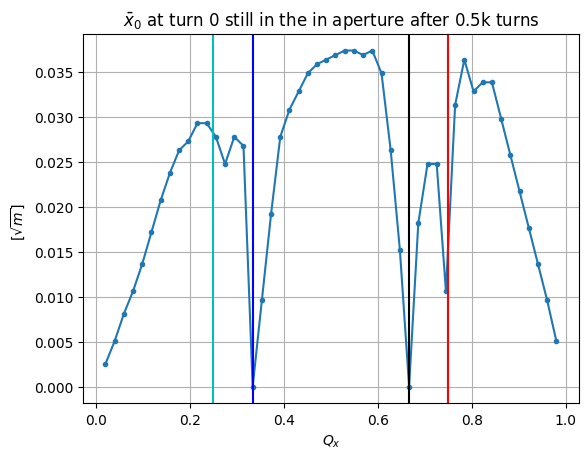

In [150]:
plt.plot(myQRange,DA_mm_at1000,'.-')
plt.axvline(1/4, c='c')
plt.axvline(1/3, c='b')
plt.axvline(2/3, c='k')
plt.axvline(3/4, c='r')
plt.xlabel('$Q_x$')
plt.ylabel('[$\sqrt{m}$]  ')
plt.title('$\\bar{x}_0$ at turn 0 still in the in aperture after 0.5k turns')
plt.grid(True)

In [151]:
interactive_plot = interactive(henonMap, Q=(0.0, 1.0, 0.001), phi0=(0, 0, 1), a=(0, .1, .0001),g=(-23*2,0,1),Nturns=(0,1000,1),Namplitude=(10,50,1),continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.5, description='Q', max=1.0, step=0.001), IntSlider(value=0, descrip…

## Per aspera ad astra.
From wikipidia [Kirkwood gaps](https://en.wikipedia.org/wiki/Kirkwood_gap)

<img src="https://upload.wikimedia.org/wikipedia/commons/3/38/Kirkwood-20060509.png" width="400">


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/Kirkwood_Gaps.svg/2560px-Kirkwood_Gaps.svg.png" width="400">



### Thank you for your attention.

## Extra

In [225]:
#ring.to_json('./cas24.json', indent=2)

In [262]:
ring = xt.Line.from_json('./cas24.json')
ring.insert_element('test',xt.LimitRect(min_x=-1e-3, max_x=1e-3, min_y=-2e-3, max_y=2e-3), at_s = 0)

Loading line from dict:   0%|          | 0/658 [00:00<?, ?it/s]

Done loading line from dict.           


In [263]:
ring.vars.get_table().to_pandas().head(14)

name      value  expr
0        t_turn_s   0.000000  None
1              k1   0.141421  None
2         trim_kf   0.000658  None
3         trim_kd  -0.002969  None
4           k1s_f   0.000000  None
5           k1s_d   0.000000  None
6            k2_f   0.420267  None
7            k2_d  -0.839359  None
8            k3_f -10.000000  None
9            k3_d  20.000000  None
10   rf_frequency   0.000000  None
11        voltage   0.000000  None
12  k0_mc.1.cell0   0.000000  None
13  k0_mc.2.cell0   0.000000  None

In [264]:
ring.vars['voltage']._info()

#  vars['voltage']._get_value()
   vars['voltage'] = 0

#  vars['voltage']._expr is None

#  vars['voltage']._find_dependant_targets()
   element_refs['rf.cell24'].voltage
   element_refs['rf.cell23'].voltage
   element_refs['rf.cell22'].voltage
   element_refs['rf.cell21'].voltage
   element_refs['rf.cell20'].voltage
   ... set _info(limit=None) to get all lines



In [297]:
import xobjects as xo
import warnings
import xpart as xp
import xplt

context = xo.ContextCpu()         # For CPU
# context = xo.ContextCupy()      # For CUDA GPUs
# context = xo.ContextPyopencl()  # For OpenCL GPUs
ring = xt.Line.from_json('./cas24.json')
ring.insert_element('test',xt.LimitRect(min_x=-5e-2, max_x=5e-2, min_y=-2.5e-2, max_y=2.5e-2), at_s = 0)

## Transfer lattice on context and compile tracking code
ring.build_tracker(_context=context)

opt = ring.match(
    vary=[
        xt.VaryList(['k2_f','k2_d'], step=1e-5),
        xt.VaryList(['trim_kf','trim_kd'], step=1e-5),
    ],
    targets = [
        xt.TargetSet(dqx=15, dqy=15, tol=1e-3),
        xt.TargetSet(qx=6.01, qy=6.01, tol=1e-3),
    ])

ring['k3_f'] = 100
ring['k3_d'] = 100
my_twiss = ring.twiss()

n_part = 100
sigma_z = 2.

from scipy.integrate import IntegrationWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=IntegrationWarning)
    particles = xp.generate_matched_gaussian_bunch(
             num_particles=n_part, #total_intensity_particles=1e10,
             nemitt_x=5e-6, nemitt_y=5e-6, sigma_z=2,
             line=ring)


Loading line from dict:   0%|          | 0/658 [00:00<?, ?it/s]

Done loading line from dict.           
Matching: model call n. 18               

*** Maximum RMS bunch length 7.880434640492812m.
... distance to target bunch length: -2.0000e+00
... distance to target bunch length: 5.6629e+00
... distance to target bunch length: 2.4669e+00
... distance to target bunch length: -1.1371e-01
... distance to target bunch length: -2.6274e-03
... distance to target bunch length: -1.8568e-06
... distance to target bunch length: 8.4856e-06
--> Bunch length: 1.9999981431837117
--> Emittance: 0.41905607665520966


In [385]:
n_turns = 100000
my_twiss.T_rev0*n_turns
ring.track(particles, num_turns=n_turns,
              turn_by_turn_monitor=False)

np.float64(0.17907447748564212)

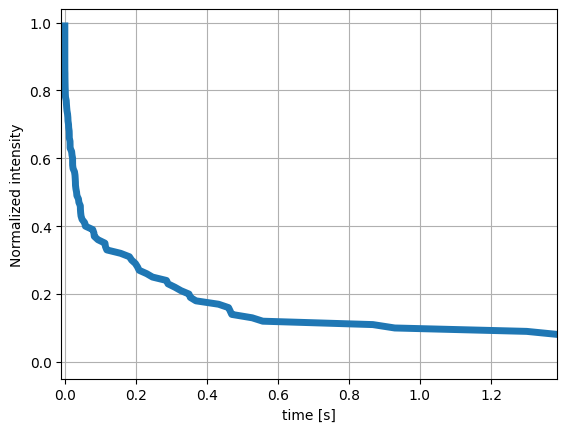

In [413]:
aux = particles.to_pandas()
aux_ref = particle_ref.to_pandas()
import matplotlib.pyplot as plt
particle_lost = aux[aux['state']==0]
particle_survived = aux[aux['state']==1]
# plt.plot(particle_lost['x'], particle_lost['px'],'or')
# plt.plot(particle_survived['x'], particle_survived['px'],'og')

# plt.figure()
# plt.plot(particle_lost['y'], particle_lost['py'],'or')
# plt.plot(particle_survived['y'], particle_survived['py'],'og')

# plt.figure()
# plt.plot(particle_lost['zeta'], particle_lost['delta'],'or')
# plt.plot(particle_survived['zeta'], particle_survived['delta'],'og')
plt.plot(aux['at_turn']*my_twiss.T_rev0, aux.index/100, lw = 5),
plt.xlabel('time [s]')
plt.ylabel('Normalized intensity')
plt.xlim(-0.01, max(my_tracking['at_turn']*my_twiss.T_rev0)-.01)
plt.grid(True)

In [393]:
particles.to_pandas().to_parquet('test.parquet')

In [394]:
my_tracking = pd.read_parquet('test.parquet')